In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import os
import shutil
import re
import numpy as np
import anndata as ad
import pooch

In [2]:
os.getcwd()

'd:\\一些资料\\生物\\计算肿瘤免疫\\single-cell-analysis\\notebooks'

In [3]:
os.chdir("..") 

In [8]:
print(os.getcwd())

d:\一些资料\生物\计算肿瘤免疫\single-cell-analysis\data


In [9]:
fs = [os.path.join('GSE207654', f) for f in os.listdir('GSE207654') if 'genes' in f]
print(fs)
samples1 = fs

['GSE207654\\GSM6304413_EB_D0.genes.tsv.gz', 'GSE207654\\GSM6304414_iMK_D3.genes.tsv.gz', 'GSE207654\\GSM6304415_iMK_D5.genes.tsv.gz', 'GSE207654\\GSM6304416_iMK_D7.genes.tsv.gz']


In [10]:
samples2 = [re.findall(r'GSM\d+', f)[0] for f in fs]
print(samples2)

['GSM6304413', 'GSM6304414', 'GSM6304415', 'GSM6304416']


In [11]:
sample_to_file = {}
 
for filepath in samples1:
    # 从文件路径里提取样本ID，和samples2格式对应
    # 这里用正则匹配 'GSM' + 数字，比如 GSM12345
    match = re.findall(r'GSM\d+', filepath)
    if match:
        sample_id = match[0]
        sample_to_file[sample_id] = filepath
 
print(sample_to_file)

{'GSM6304413': 'GSE207654\\GSM6304413_EB_D0.genes.tsv.gz', 'GSM6304414': 'GSE207654\\GSM6304414_iMK_D3.genes.tsv.gz', 'GSM6304415': 'GSE207654\\GSM6304415_iMK_D5.genes.tsv.gz', 'GSM6304416': 'GSE207654\\GSM6304416_iMK_D7.genes.tsv.gz'}


In [12]:
# 创建 outputs 文件夹（如果不存在）
os.makedirs('outputs', exist_ok=True)
 
# 遍历 samples2 ，根据样本ID找到对应文件路径进行复制
for sample_id in samples2:
    if sample_id not in sample_to_file:
        print(f"警告：找不到样本 {sample_id} 对应的文件！")
        continue
 
    y = sample_to_file[sample_id]
 
    output_dir = os.path.join('outputs', sample_id)
    os.makedirs(output_dir, exist_ok=True)
 
    # 复制并重命名 features 文件
    shutil.copy(y, os.path.join(output_dir, 'genes.tsv.gz'))
 
    # 对应的 matrix 文件名替换，构建出matrix文件，并转移
    matrix_file = y.replace('genes', 'matrix').replace('.tsv', '.mtx')
    shutil.copy(matrix_file, os.path.join(output_dir, 'matrix.mtx.gz'))
 
    # 对应的 barcodes 文件名替换，构建出barcodes文件，并转移
    barcodes_file = y.replace('genes', 'barcodes')
    shutil.copy(barcodes_file, os.path.join(output_dir, 'barcodes.tsv.gz'))

In [13]:
np.random.seed(42)  # 或其他你选择的数字

In [14]:
sc.settings.set_figure_params(dpi=100, facecolor="white")

In [15]:
os.makedirs("1-DataPre",exist_ok=True)

In [16]:
os.getcwd()

'd:\\一些资料\\生物\\计算肿瘤免疫\\single-cell-analysis\\data'

In [17]:
samples = [s for s in os.listdir('./outputs') if not s.startswith('.')]
samples

['GSM6304413', 'GSM6304414', 'GSM6304415', 'GSM6304416']

# 2. Preprocessing and Quality Control 预处理和质量控制 

#### A. removal of low expression genes, cell quality control, filtration and expression count normalization.
For datasets with multiple batches, we carried out partial quality control at the time of reading (the paper did not mention specific filtering parameters, we chose common parameters)


In [18]:
import scanpy as sc
import os
import gzip
import pandas as pd
from scipy.io import mmread

def read_old_10x_mtx(sample_path, var_names='gene_symbols'):
    """
    手动读取旧版10x数据（genes.tsv.gz格式）
    """
    # 定义文件路径
    matrix_path = os.path.join(sample_path, 'matrix.mtx.gz')
    genes_path = os.path.join(sample_path, 'genes.tsv.gz')
    barcodes_path = os.path.join(sample_path, 'barcodes.tsv.gz')
    
    # 读取表达矩阵
    expr_matrix = mmread(matrix_path).tocsr()
    
    # 读取基因信息（旧版genes.tsv.gz是两列：ENSG ID + 基因名）
    with gzip.open(genes_path, 'rt') as f:
        genes = pd.read_csv(f, sep='\t', header=None, names=['ensembl_id', 'gene_symbol'])
    
    # 读取barcode信息
    with gzip.open(barcodes_path, 'rt') as f:
        barcodes = pd.read_csv(f, sep='\t', header=None, names=['barcode'])
    
    # 创建AnnData对象
    adata = sc.AnnData(X=expr_matrix.T)  # 注意转置：scanpy中行为细胞，列为基因
    adata.obs_names = barcodes['barcode'].values
    adata.var_names = genes['gene_symbol'].values if var_names == 'gene_symbols' else genes['ensembl_id'].values
    adata.var['ensembl_id'] = genes['ensembl_id'].values  # 保留ENSG ID信息
    
    return adata

# 主循环
sce_list = []
dir_path = r'D:\一些资料\生物\计算肿瘤免疫\single-cell-analysis\data\outputs' #change to your path(outputs folder)
samples = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]

for s in samples:
    sample_path = os.path.join(dir_path, s)
    print(f"\n===== 处理样本: {s} =====")
    print(f"样本路径: {sample_path}")

    # 对于具有多个批次的数据集，应单独对每个样品进行质量控制
    try:
        # 使用自定义函数读取旧版数据
        adata = read_old_10x_mtx(sample_path, var_names='gene_symbols')
        
        # 处理重复基因名（如果有的话）
        adata.var_names_make_unique()
        
        # 质量过滤   至少5个细胞的基因，至少300个基因的细胞 (对应min.cells和min.features)
        sc.pp.filter_genes(adata, min_cells=5)
        sc.pp.filter_cells(adata, min_genes=300)
        adata.obs['project'] = s
        
        sce_list.append(adata)
        print(f"✅ 样本{s}处理成功！细胞数：{adata.n_obs}，基因数：{adata.n_vars}")
        
    except Exception as e:
        print(f"❌ 样本{s}读取失败！错误原因：{str(e)[:200]}")

print(f"\n最终成功处理的样本数：{len(sce_list)}")


===== 处理样本: GSM6304413 =====
样本路径: D:\一些资料\生物\计算肿瘤免疫\single-cell-analysis\data\outputs\GSM6304413
✅ 样本GSM6304413处理成功！细胞数：11752，基因数：18270

===== 处理样本: GSM6304414 =====
样本路径: D:\一些资料\生物\计算肿瘤免疫\single-cell-analysis\data\outputs\GSM6304414
✅ 样本GSM6304414处理成功！细胞数：19428，基因数：18341

===== 处理样本: GSM6304415 =====
样本路径: D:\一些资料\生物\计算肿瘤免疫\single-cell-analysis\data\outputs\GSM6304415
✅ 样本GSM6304415处理成功！细胞数：9128，基因数：18844

===== 处理样本: GSM6304416 =====
样本路径: D:\一些资料\生物\计算肿瘤免疫\single-cell-analysis\data\outputs\GSM6304416
✅ 样本GSM6304416处理成功！细胞数：10603，基因数：18465

最终成功处理的样本数：4


In [19]:
sce_list

[AnnData object with n_obs × n_vars = 11752 × 18270
     obs: 'n_genes', 'project'
     var: 'ensembl_id', 'n_cells',
 AnnData object with n_obs × n_vars = 19428 × 18341
     obs: 'n_genes', 'project'
     var: 'ensembl_id', 'n_cells',
 AnnData object with n_obs × n_vars = 9128 × 18844
     obs: 'n_genes', 'project'
     var: 'ensembl_id', 'n_cells',
 AnnData object with n_obs × n_vars = 10603 × 18465
     obs: 'n_genes', 'project'
     var: 'ensembl_id', 'n_cells']

In [20]:
adata = sc.concat(sce_list,label="sampleid",index_unique='_')
adata.obs_names_make_unique

<bound method AnnData.obs_names_make_unique of AnnData object with n_obs × n_vars = 50911 × 16437
    obs: 'n_genes', 'project', 'sampleid'>

In [16]:
#pip install array-api-compat

In [21]:
adata.write('./1-DataPre/GSE188711.h5ad')

In [22]:
os.chdir("./1-DataPre/")
os.getcwd()

'd:\\一些资料\\生物\\计算肿瘤免疫\\single-cell-analysis\\data\\1-DataPre'

In [23]:
adata = sc.read_h5ad("GSE188711.h5ad")

In [24]:
#添加注释 var
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [25]:
adata.var # 可以看到每个基因的元数据

mt   ribo     hb
RP11-34P13.7   False  False  False
AL627309.1     False  False  False
AP006222.2     False  False  False
RP4-669L17.10  False  False  False
RP11-206L10.3  False  False  False
...              ...    ...    ...
AC011043.1     False  False  False
AL592183.1     False  False  False
AC011841.1     False  False  False
AL354822.1     False  False  False
SRSF10-1       False  False  False

[16437 rows x 3 columns]

In [26]:
adata.obs # 可以看到每个细胞的元数据

n_genes     project sampleid
AAACCCAAGAAACACT-1_0     5132  GSM6304413        0
AAACCCAAGCAGGGAG-1_0     4846  GSM6304413        0
AAACCCAAGGCTCTAT-1_0     5614  GSM6304413        0
AAACCCAAGTCGCCCA-1_0     5095  GSM6304413        0
AAACCCACACAACGTT-1_0     5344  GSM6304413        0
...                       ...         ...      ...
TTTGTTGAGCACTCGC-1_3     3291  GSM6304416        3
TTTGTTGAGTGAGGCT-1_3     2468  GSM6304416        3
TTTGTTGCAACTGGTT-1_3     4402  GSM6304416        3
TTTGTTGCACGCGTCA-1_3     4559  GSM6304416        3
TTTGTTGCATCACAGT-1_3     4036  GSM6304416        3

[50911 rows x 3 columns]

In [27]:
# 计算每个细胞针对指定基因集的质量控制指标
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

In [24]:
adata.var.head()

mt   ribo     hb  n_cells_by_counts  mean_counts  \
RP11-34P13.7   False  False  False                279     0.005559   
AL627309.1     False  False  False                899     0.019367   
AP006222.2     False  False  False               7202     0.171731   
RP4-669L17.10  False  False  False                426     0.008485   
RP11-206L10.3  False  False  False               2065     0.043173   

               log1p_mean_counts  pct_dropout_by_counts  total_counts  \
RP11-34P13.7            0.005543              99.451985           283   
AL627309.1              0.019182              98.234173           986   
AP006222.2              0.158482              85.853745          8743   
RP4-669L17.10           0.008450              99.163246           432   
RP11-206L10.3           0.042267              95.943902          2198   

               log1p_total_counts  
RP11-34P13.7             5.648974  
AL627309.1               6.894670  
AP006222.2               9.076123  
RP4-669L17.10            6.070738  
RP11-206L10.3            7.695758

In [25]:
adata.obs.head()

n_genes     project sampleid  n_genes_by_counts  \
AAACCCAAGAAACACT-1_0     5132  GSM6304413        0               5125   
AAACCCAAGCAGGGAG-1_0     4846  GSM6304413        0               4829   
AAACCCAAGGCTCTAT-1_0     5614  GSM6304413        0               5607   
AAACCCAAGTCGCCCA-1_0     5095  GSM6304413        0               5081   
AAACCCACACAACGTT-1_0     5344  GSM6304413        0               5337   

                      log1p_n_genes_by_counts  total_counts  \
AAACCCAAGAAACACT-1_0                 8.542081         31768   
AAACCCAAGCAGGGAG-1_0                 8.482602         29628   
AAACCCAAGGCTCTAT-1_0                 8.631949         32796   
AAACCCAAGTCGCCCA-1_0                 8.533460         27414   
AAACCCACACAACGTT-1_0                 8.582606         28811   

                      log1p_total_counts  pct_counts_in_top_50_genes  \
AAACCCAAGAAACACT-1_0           10.366246                   38.047721   
AAACCCAAGCAGGGAG-1_0           10.296509                   34.035372   
AAACCCAAGGCTCTAT-1_0           10.398092                   25.923893   
AAACCCAAGTCGCCCA-1_0           10.218846                   28.113373   
AAACCCACACAACGTT-1_0           10.268547                   27.142411   

                      pct_counts_in_top_100_genes  \
AAACCCAAGAAACACT-1_0                    52.738605   
AAACCCAAGCAGGGAG-1_0                    48.869313   
AAACCCAAGGCTCTAT-1_0                    38.120503   
AAACCCAAGTCGCCCA-1_0                    41.343839   
AAACCCACACAACGTT-1_0                    40.564368   

                      pct_counts_in_top_200_genes  \
AAACCCAAGAAACACT-1_0                    60.331151   
AAACCCAAGCAGGGAG-1_0                    58.370460   
AAACCCAAGGCTCTAT-1_0                    47.990609   
AAACCCAAGTCGCCCA-1_0                    50.488801   
AAACCCACACAACGTT-1_0                    50.074624   

                      pct_counts_in_top_500_genes  total_counts_mt  \
AAACCCAAGAAACACT-1_0                    69.686477             3398   
AAACCCAAGCAGGGAG-1_0                    68.992170             2506   
AAACCCAAGGCTCTAT-1_0                    60.653738             2665   
AAACCCAAGTCGCCCA-1_0                    63.073612             2005   
AAACCCACACAACGTT-1_0                    61.948561             2082   

                      log1p_total_counts_mt  pct_counts_mt  total_counts_ribo  \
AAACCCAAGAAACACT-1_0               8.131237      10.696298              10339   
AAACCCAAGCAGGGAG-1_0               7.826842       8.458215               9088   
AAACCCAAGGCTCTAT-1_0               7.888335       8.125991               7770   
AAACCCAAGTCGCCCA-1_0               7.603898       7.313781               7424   
AAACCCACACAACGTT-1_0               7.641564       7.226407               7562   

                      log1p_total_counts_ribo  pct_counts_ribo  \
AAACCCAAGAAACACT-1_0                 9.243775        32.545329   
AAACCCAAGCAGGGAG-1_0                 9.114820        30.673687   
AAACCCAAGGCTCTAT-1_0                 8.958154        23.691914   
AAACCCAAGTCGCCCA-1_0                 8.912608        27.081053   
AAACCCACACAACGTT-1_0                 8.931023        26.246920   

                      total_counts_hb  log1p_total_counts_hb  pct_counts_hb  
AAACCCAAGAAACACT-1_0              243               5.497168       0.764921  
AAACCCAAGCAGGGAG-1_0             1121               7.022868       3.783583  
AAACCCAAGGCTCTAT-1_0              267               5.590987       0.814124  
AAACCCAAGTCGCCCA-1_0              507               6.230481       1.849420  
AAACCCACACAACGTT-1_0              576               6.357842       1.999236

In [26]:
#adata.obs['project']=adata.obs['project'].astype('category')  # 转为类别型变量，节省内存
# 定义GSM编号到时间点的映射字典
gsm_to_time = {
    "GSM6304413": "D0",
    "GSM6304414": "D3",
    "GSM6304415": "D5",  # 假设后续GSM编号对应D5，可根据实际补充
    "GSM6304416": "D7"   # 假设后续GSM编号对应D7，可根据实际补充
}
adata.obs['project'] = adata.obs['project'].map(gsm_to_time)
adata.obs['project'] = adata.obs['project'].astype('category')

<Axes: xlabel='pct_counts_mt', ylabel='Count'>

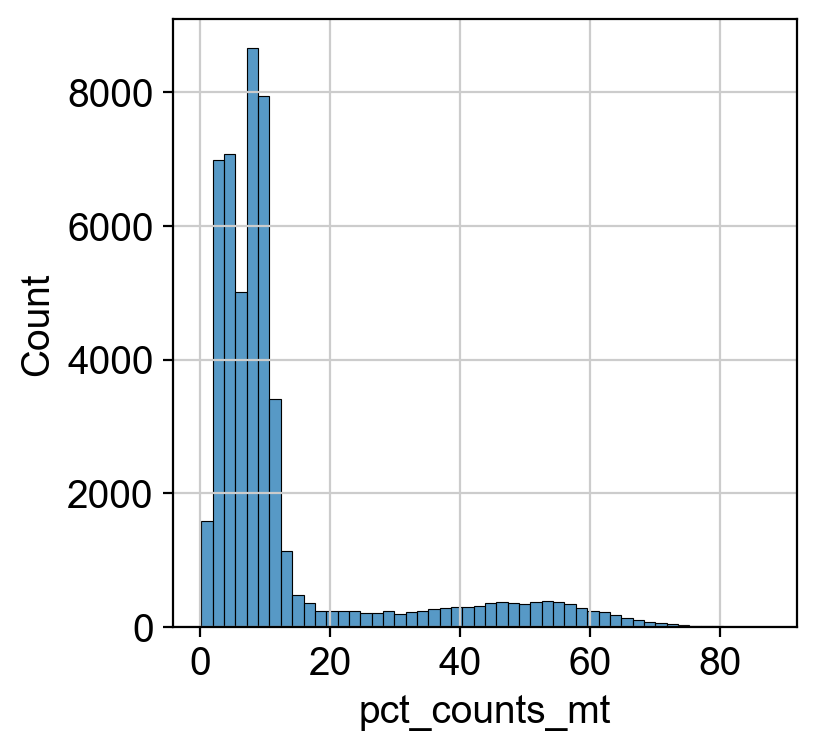

In [27]:
#直接看 QC 指标分布
import seaborn as sns
sns.histplot(adata.obs["pct_counts_mt"], bins=50)

#### b. The high proportion of mitochondria in scrna SEQ usually corresponds to low-quality cells. The core reasons include:
Apoptosis / stress: when cells are apoptotic or under stress (such as hypoxia and nutrient deficiency), nuclear membrane rupture leads to degradation of nuclear RNA, while mitochondrial structure is more stable, and mitochondrial RNA is preferentially retained. At this time, "nuclear gene signal is weakened, mitochondrial gene signal is relatively enhanced" in the sequencing data, and the proportion of mitochondria will significantly increase (>10%-15%). The
Dead cells / dying cells: nuclear RNA of dead cells is almost completely degraded, leaving only mitochondrial RNA and a small amount of residual cytosolic RNA. The proportion of mitochondria may exceed 50% or even higher. The
Incomplete cell lysis: in the experimental operation, if the cell lysis is not sufficient and the release of nuclear RNA is insufficient, the proportion of mitochondrial RNA will also passively increase. The
Scrna SEQ (especially 10x genomics technology) relies on the integrity of cells: if dead or apoptotic cells are captured, the RNA fragments after degradation are not the "real transcriptome of living cells" obtained by sequencing. These low-quality data will interfere with subsequent cell clustering and difference analysis (such as the formation of "pseudo cell clusters"), which must be filtered through indicators such as mitochondrial proportion. The

#### c. Draw the "nfeature_rna", "ncount_rna" and "percent.mt" graphs before quality control
(where pct_counts_mt is percent.mt, n_genes_by_counts is nfeature_rna, and total_counts is ncount_rna)

<Figure size 1968.5x393.701 with 0 Axes>

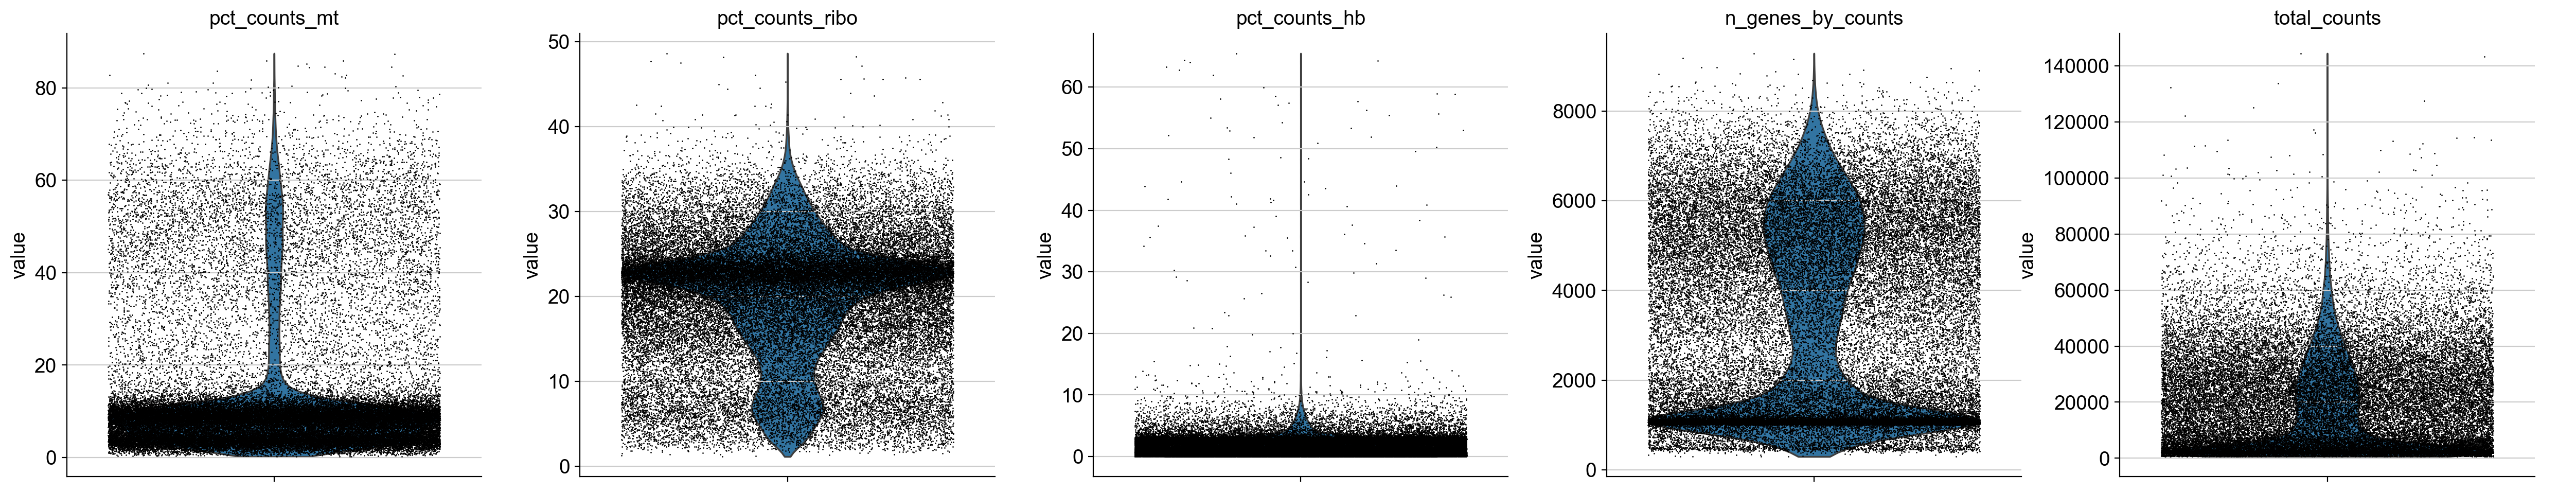

In [28]:
width_cm = 50
height_cm = 10
plt.figure(figsize=(width_cm / 2.54, height_cm / 2.54))
 
sc.pl.violin(
    adata,
    ["pct_counts_mt", "pct_counts_ribo","pct_counts_hb","n_genes_by_counts", "total_counts"],
    jitter=0.4,# 横向抖动防止重叠
    multi_panel=True, # 绘制在单独的子图中
    show=False
)
 
plt.savefig("过滤前.pdf",bbox_inches='tight') # 不显示就能保存了。。。。show =False
plt.show()

==========Cells were filtered according to the paper threshold==========
1. filter the cells with library size <2500 (total_counts is the library size)
2. filter the cells with the proportion of mitochondria >15% (pct_counts_mt is the proportion of mitochondria)

In [29]:
sc.pp.filter_cells(adata, min_counts=2500)  # 文库大小≥2500
adata = adata[adata.obs['pct_counts_mt'] < 15, :]  # 线粒体比例<15%

#### c. Draw the "nfeature_rna", "ncount_rna" and "percent.mt" diagrams after quality control, and explain their meanings.
A high percentage of mitochondrial genes may indicate cell damage or stress status; The percentage of ribosomal genes reflects the translational activity of the cell; A high percentage of hemoglobin genes may indicate the presence of red blood cell contamination in the sample; The number of detected genes and the total number of UMIS reflect the depth and complexity of cell sequencing. By setting reasonable filtering conditions, low-quality cells and potentially noisy data can be effectively removed, thereby improving the overall quality of single-cell sequencing data. The filtered data are more evenly distributed, reducing the impact of outliers, and providing a more reliable basis for subsequent cell clustering, differential expression analysis and biological function research. The figure shows the distribution of quality control indicators of filtered data, verifies the effectiveness of filtering steps, and ensures the accuracy and reliability of subsequent analysis.

d:\Anaconda\envs\scRNA_new\lib\site-packages\scanpy\plotting\_anndata.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g: sns.axisgrid.FacetGrid = sns.catplot(


<Figure size 1968.5x393.701 with 0 Axes>

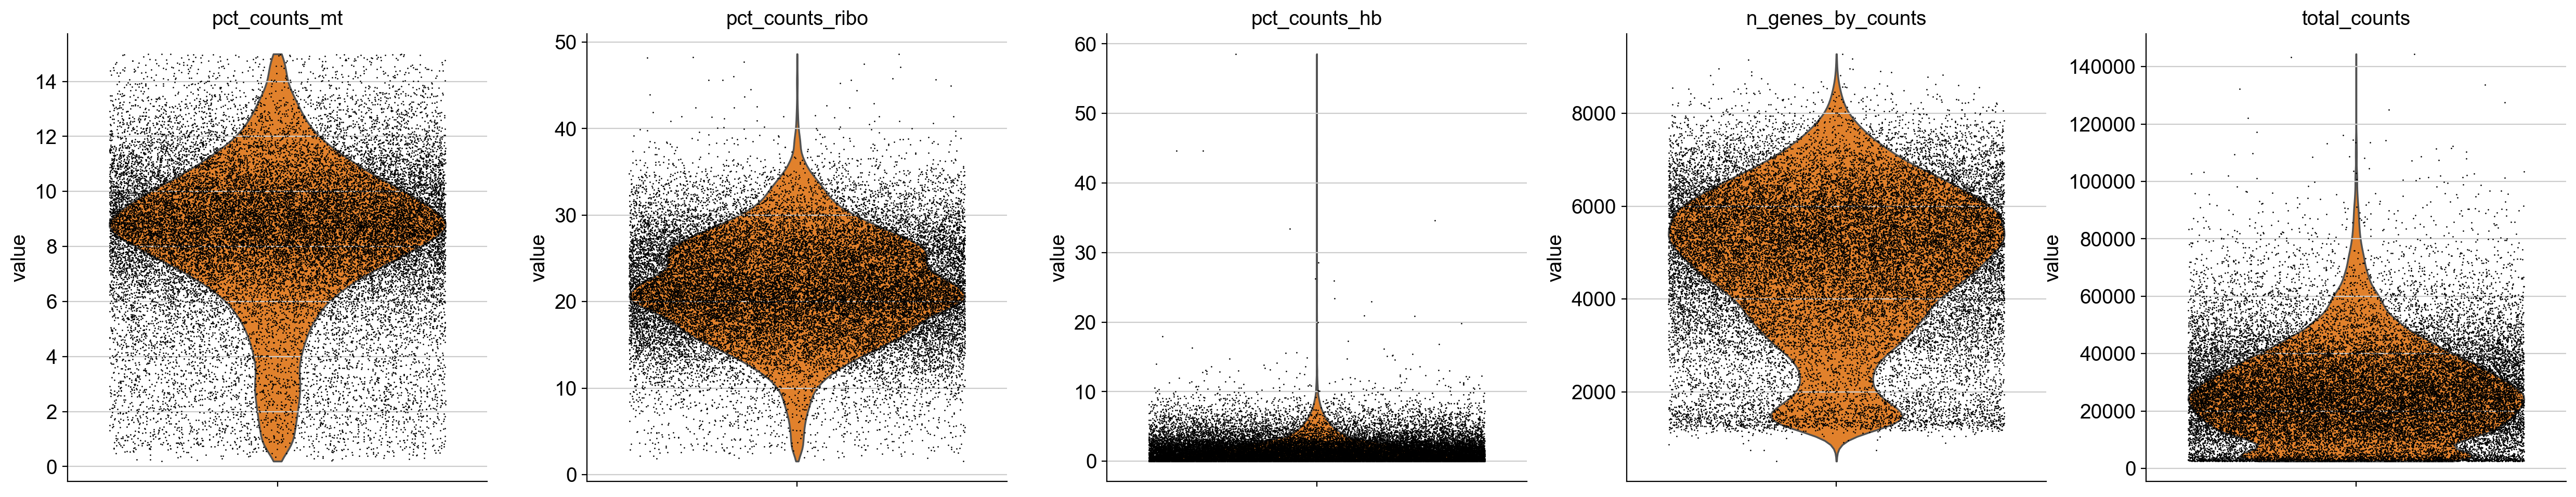

In [30]:
width_cm = 50
height_cm = 10
plt.figure(figsize=(width_cm / 2.54, height_cm / 2.54))
 
sc.pl.violin(
    adata,
    ["pct_counts_mt", "pct_counts_ribo","pct_counts_hb","n_genes_by_counts", "total_counts"],
    jitter=0.4,# 横向抖动防止重叠
    multi_panel=True, # 绘制在单独的子图中
    #groupby='sampleid',  # 或其他 group 字段
    palette=["#ff7f0e"], #["#1f77b4",  "#2ca02c", "#d62728", "#9467bd"],
    show=False
)
 
plt.savefig("过滤后.pdf",bbox_inches='tight') # 不显示就能保存了。。。。show =False
plt.show()

<Figure size 393.701x393.701 with 0 Axes>

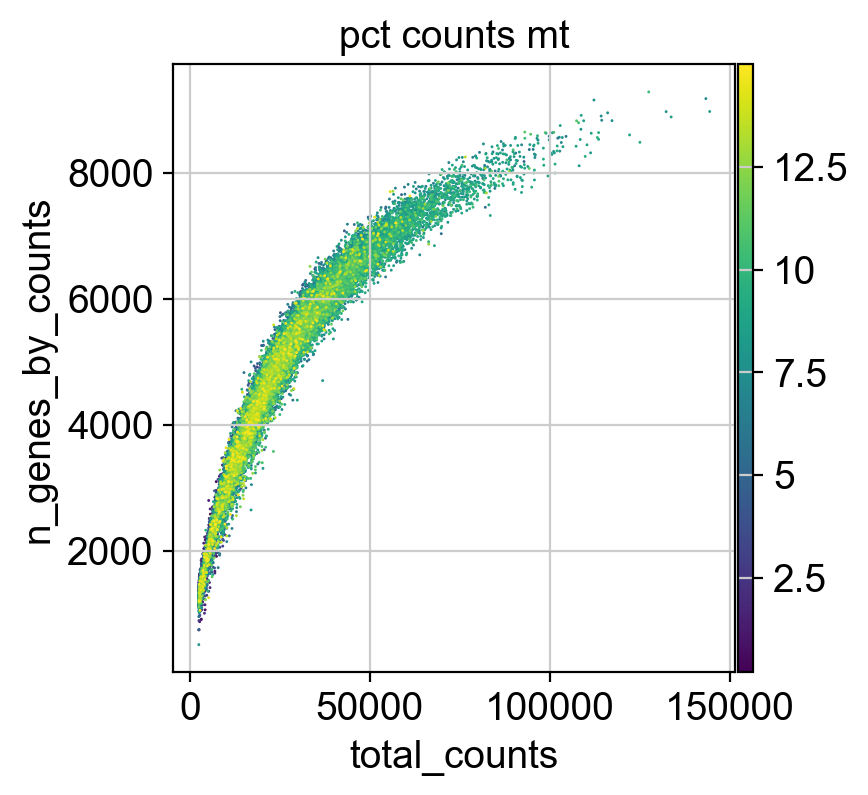

In [31]:
width_cm = 10
height_cm = 10
plt.figure(figsize=(width_cm / 2.54, height_cm / 2.54))
 
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt",show=False)
 
plt.savefig("scatterPlot.pdf",bbox_inches='tight') 
plt.show()

The paper mentioned that after filtering, we use the standard workflow implemented in monocle3 to process data. We use python, so we don't use its method

#### a. In single-cell sequencing, some droplets may contain multiple cells, called "double cells", which will lead to inaccurate biological interpretation. A double cell removal algorithm was selected to remove double cells from the data set, and the effect of removing double cells on the results was evaluated.

In [32]:
 # 使用scrublet进行双细胞检测     doublet_score:0–1 双细胞打分，越大越像双细胞 predicted_doublet:True/False，是否被预测为双细胞
sc.pp.scrublet(adata, batch_key="sampleid")

In [33]:
# 保留单细胞（非 doublet）
#adata = adata[~adata.obs['predicted_doublet']].copy()
#print(f"去除双细胞后剩余细胞数: {adata.n_obs}")

In [34]:
# 保存原始count矩阵数据 
# 这一步也可以不用
adata.layers["counts"] = adata.X.copy()
adata.layers


Layers with keys: counts

#### a. Low expression genes were removed, cell quality control, filtering, and expression count normalization.
The following is the standardization of expression technology

In [35]:
# Normalizing to median total counts
sc.pp.normalize_total(adata,target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata)

In [36]:
# 保存一个原始数据
adata.raw = adata.copy()

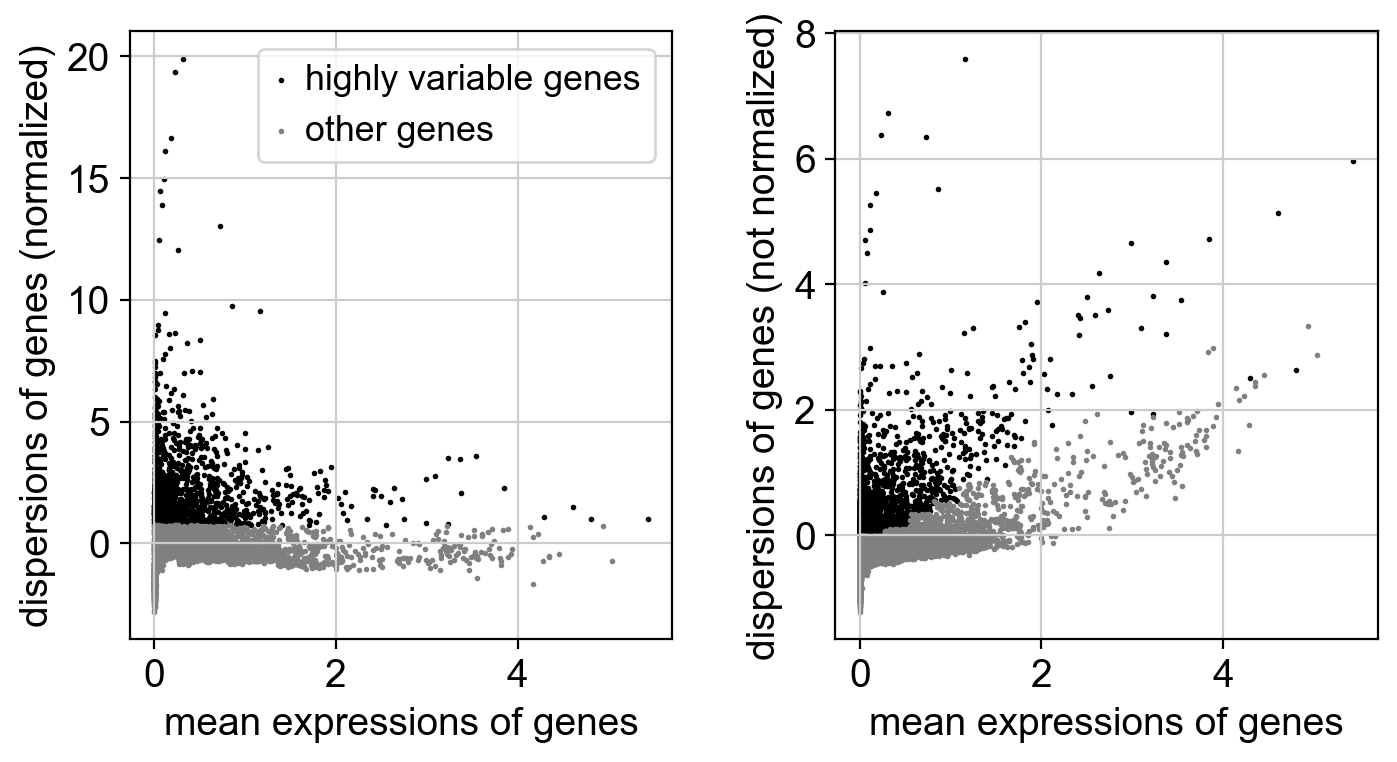

In [37]:
# 全部
#sc.pp.highly_variable_genes(adata, n_top_genes=adata.shape[1], batch_key="sampleid")
#sc.pl.highly_variable_genes(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)  # 先选高变基因
sc.pl.highly_variable_genes(adata)

In [38]:
# 此列表来自论文的参考文献的补充资料
# G1/S 期基因列表
g1_s_list = [
    'ACD', 'ACYP1', 'ADAMTS1', 'ANKRD10', 'APEX2', 'ARGLU1', 'ATAD2', 'BARD1', 'BRD7', 'C1orf63', 
    'C7orf41', 'C14orf142', 'CAPN7', 'CASP2', 'CASP8AP2', 'CCNE1', 'CCNE2', 'CDC6', 'CDC25A', 'CDCA7', 
    'CDCA7L', 'CEP57', 'CHAF1A', 'CHAF1B', 'CLSPN', 'CREBZF', 'CTSD', 'DIS3', 'DNAJC3', 'DONSON', 
    'DSCC1', 'DTL', 'E2F1', 'EIF2A', 'ESD', 'FAM105B', 'FAM122A', 'FLAD1', 'GINS2', 'GINS3', 
    'GMNN', 'HELLS', 'HOXB4', 'HRAS', 'HSF2', 'INSR', 'INTS8', 'IVNS1ABP', 'KIAA1147', 'KIAA1586', 
    'LNPEP', 'LUC7L3', 'MCM2', 'MCM4', 'MCM5', 'MCM6', 'MDM1', 'MED31', 'MRI1', 'MSH2', 
    'NASP', 'NEAT1', 'NKTR', 'NPAT', 'NUP43', 'ORC1', 'OSBPL6', 'PANK2', 'PCDH7', 'PCNA', 
    'PLCXD1', 'PMS1', 'PNN', 'POLD3', 'RAB23', 'RECQL4', 'RMI2', 'RNF113A', 'RNPC3', 'SEC62', 
    'SKP2', 'SLBP', 'SLC25A36', 'SNHG10', 'SRSF7', 'SSR3', 'TAF15', 'TIPIN', 'TOPBP1', 'TRA2A', 
    'TTC14', 'UBR7', 'UHRF1', 'UNG', 'USP53', 'VPS72', 'WDR76', 'ZMYND19', 'ZNF367', 'ZRANB2'
]

# S 期基因列表
s_list = [
    'ABCC5', 'ABHD10', 'ANKRD18A', 'ASF1B', 'ATAD2', 'BBS2', 'BIVM', 'BLM', 'BMI1', 'BRCA1', 
    'BRIP1', 'C5orf42', 'C11orf82', 'CALD1', 'CALM2', 'CASP2', 'CCDC14', 'CCDC84', 'CCDC150', 'CDC7', 
    'CDC45', 'CDCA5', 'CDKN2AIP', 'CENPM', 'CENPQ', 'CERS6', 'CHML', 'COQ9', 'CPNE8', 'CREBZF', 
    'CRLS1', 'DCAF16', 'DEPDC7', 'DHFR', 'DNA2', 'DNAJB4', 'DONSON', 'DSCC1', 'DYNC1LI2', 'E2F8', 
    'EIF4EBP2', 'ENOSF1', 'ESCO2', 'EXO1', 'EZH2', 'FAM178A', 'FANCA', 'FANCI', 'FEN1', 'GCLM', 
    'GOLGA8A', 'GOLGA8B', 'H1F0', 'HELLS', 'HIST1H2AC', 'HIST1H4C', 'INTS7', 'KAT2A', 'KAT2B', 'KDELC1', 
    'KIAA1598', 'LMO4', 'LYRM7', 'MAN1A2', 'MASTL', 'MBD4', 'MCM8', 'MLF1IP', 'MYCBP2', 'NAB1', 
    'NFE2L2', 'NRD1', 'NSUN3', 'NT5DC1', 'NUP160', 'OGT', 'ORC3', 'OSGIN2', 'PHIP', 'PHTF1', 
    'PHTF2', 'PKMYT1', 'POLA1', 'PRIM1', 'PTAR1', 'RAD18', 'RAD51', 'RAD51AP1', 'RBBP8', 'REEP1', 
    'RFC2', 'RHOBTB3', 'RMI1', 'RPA2', 'RRM1', 'RRM2', 'RSRC2', 'SAP30BP', 'SLC38A2', 'SP1', 
    'SRSF5', 'SVIP', 'TOP2A', 'TTC31', 'TTLL7', 'TYMS', 'UBE2T', 'UBL3', 'USP1', 'ZBED5', 'ZWINT'
]

# G2/M 期基因列表
g2_m_list = [
    'ANLN', 'AP3D1', 'ARHGAP19', 'ARL4A', 'ARMC1', 'ASXL1', 'ATL2', 'AURKB', 'BCLAF1', 'BORA', 
    'BRD8', 'BUB3', 'C2orf69', 'C14orf80', 'CASP3', 'CBX5', 'CCDC107', 'CCNA2', 'CCNF', 'CDC16', 
    'CDC25C', 'CDCA2', 'CDCA3', 'CDCA8', 'CDK1', 'CDKN1B', 'CDKN2C', 'CDR2', 'CENPL', 'CEP350', 
    'CFD', 'CFLAR', 'CHEK2', 'CKAP2', 'CKAP2L', 'CYTH2', 'DCAF7', 'DHX8', 'DNAJB1', 'ENTPD5', 
    'ESPL1', 'FADD', 'FAN1', 'FANCD2', 'G2E3', 'GABPB1', 'GAS1', 'GAS2L3', 'H2AFX', 'HAUS8', 
    'HINT3', 'HIPK2', 'HJURP', 'HMGB2', 'HN1', 'HP1BP3', 'HRSP12', 'IFNAR1', 'IQGAP3', 'KATNA1', 
    'KCTD9', 'KDM4A', 'KIAA1524', 'KIF5B', 'KIF11', 'KIF20B', 'KIF22', 'KIF23', 'KIFC1', 'KLF6', 
    'LBR', 'LIX1L', 'LMNB1', 'MAD2L1', 'MALAT1', 'MELK', 'MGAT2', 'MID1', 'MIS18BP1', 'MND1', 
    'NCAPD3', 'NCAPH', 'NCOA5', 'NDC80', 'NEIL3', 'NFIC', 'NIPBL', 'NMB', 'NR3C1', 'NUCKS1', 
    'NUMA1', 'NUSAP1', 'PIF1', 'PKNOX1', 'POLQ', 'PPP1R2', 'PSMD11', 'PSRC1', 'RANGAP1', 'RCCD1', 
    'RDH11', 'RNF141', 'SAP30', 'SKA3', 'SMC4', 'STAT1', 'STIL', 'STK17B', 'SUCLG2', 'TFAP2A', 
    'TIMP1', 'TMEM99', 'TMPO', 'TNPO2', 'TOP2A', 'TRAIP', 'TRIM59', 'TRMT2A', 'TTF2', 'TUBA1A', 
    'TUBB', 'TUBB2A', 'TUBB4B', 'TUBD1', 'UACA', 'UBE2C', 'VPS25', 'VTA1', 'WSB1', 'ZNF587', 'ZNHIT2'
]

# M 期基因列表
m_list = [
    'AHI1', 'AKIRIN2', 'ANKRD40', 'ANLN', 'ANP32B', 'ANP32E', 'ARHGAP19', 'ARL6IP1', 'ASXL1', 'ATF7IP', 
    'AURKA', 'BIRC2', 'BIRC5', 'BUB1', 'CADM1', 'CCDC88A', 'CCDC90B', 'CCNA2', 'CCNB2', 'CDC20', 
    'CDC25B', 'CDC27', 'CDC42EP1', 'CDCA3', 'CENPA', 'CENPE', 'CENPF', 'CEP55', 'CFLAR', 'CIT', 
    'CKAP2', 'CKAP5', 'CKS1B', 'CKS2', 'CNOT10', 'CNTROB', 'CTCF', 'CTNNA1', 'CTNND1', 'DEPDC1', 
    'DEPDC1B', 'DIAPH3', 'DNAJA1', 'DNAJB1', 'DR1', 'DZIP3', 'E2F5', 'FAM64A', 'FOXM1', 'FYN', 
    'G2E3', 'GADD45A', 'GAS2L3', 'GOT1', 'GRK6', 'GTSE1', 'HCFC1', 'HMG20B', 'HMGB3', 'HMMR', 
    'HN1', 'HP1BP3', 'HPS4', 'HS2ST1', 'HSPA8', 'HSPA13', 'INADL', 'KIF2C', 'KIF5B', 'KIF14', 
    'KIF20B', 'KLF9', 'LBR', 'LMNA', 'MCM4', 'MDC1', 'MIS18BP1', 'MKI67', 'MLLT4', 'MZT1', 
    'NCAPD2', 'NCOA5', 'NEK2', 'NUF2', 'NUP35', 'NUP98', 'NUSAP1', 'ODF2', 'ORAOV1', 'PBK', 
    'PCF11', 'PLK1', 'POC1A', 'POM121', 'PPP1R10', 'PRPSAP1', 'PRR11', 'PSMG3', 'PTP4A1', 'PTPN9', 
    'PWP1', 'QRICH1', 'RAD51C', 'RANGAP1', 'RBM8A', 'RCAN1', 'RERE', 'RNF126', 'RNF141', 'RNPS1', 
    'RRP1', 'SEPHS1', 'SETD8', 'SFPQ', 'SGOL2', 'SHCBP1', 'SMARCB1', 'SMARCD1', 'SPAG5', 'SPTBN1', 
    'SRF', 'SRSF3', 'SS18', 'SUV420H1', 'TACC3', 'THRAP3', 'TLE3', 'TMEM138', 'TNPO1', 'TOMM34', 
    'TPX2', 'TRIP13', 'TSG101', 'TSN', 'TTK', 'TUBB4B', 'TXNDC9', 'TXNRD1', 'UBE2D3', 'USP13', 
    'USP16', 'VANGL1', 'WIBG', 'WSB1', 'YWHAH', 'ZC3HC1', 'ZFX', 'ZMYM1', 'ZNF207'
]

# M/G1 期基因列表
m_g1_list = [
    'AGFG1', 'AGPAT3', 'AKAP13', 'AMD1', 'ANP32E', 'ANTXR1', 'BAG3', 'BTBD3', 'CBX3', 'CDC42', 
    'CDK7', 'CDKN3', 'CEP70', 'CNIH4', 'CTR9', 'CWC15', 'DCP1A', 'DCTN6', 'DEXI', 'DKC1', 
    'DNAJB6', 'DSP', 'DYNLL1', 'EIF4E', 'ELP3', 'FAM60A', 'FAM189B', 'FOPNL', 'FOXK2', 'FXR1', 
    'G3BP1', 'GATA2', 'GNB1', 'GRPEL1', 'GSPT1', 'GTF3C4', 'HIF1A', 'HMG20B', 'HMGCR', 'HSD17B11', 
    'HSPA8', 'ILF2', 'JMJD1C', 'KDM5B', 'KIAA0586', 'KIF5B', 'KPNB1', 'KRAS', 'LARP1', 'LARP7', 
    'LRIF1', 'LYAR', 'MORF4L2', 'MRPL19', 'MRPS2', 'MRPS18B', 'MSL1', 'MTPN', 'NCOA3', 'NFIA', 
    'NFIC', 'NUCKS1', 'NUFIP2', 'NUP37', 'ODF2', 'OPN3', 'PAK1IP1', 'PCF11', 'PLIN3', 'PPP2CA', 
    'PPP2R2A', 'PPP6R3', 'PRC1', 'PSEN1', 'PTMS', 'PTTG1', 'RAD21', 'RAN', 'RHEB', 'RPL13A', 
    'SLC39A10', 'SNUPN', 'SRSF3', 'STAG1', 'SYNCRIP', 'TAF9', 'TCERG1', 'TLE3', 'TMEM138', 'TOB2', 
    'TOP1', 'TROAP', 'TSC22D1', 'TULP4', 'UBE2D3', 'VANGL1', 'VCL', 'WIPF2', 'WWC1', 'YY1', 
    'ZBTB7A', 'ZCCHC10', 'ZNF24', 'ZNF281', 'ZNF593'
]

In [39]:
# 过滤：保留adata中存在的基因（关键！避免匹配失败）
gene_sets = {
    'G1S_score': [g for g in g1_s_list if g in adata.var_names],
    'S_score': [g for g in s_list if g in adata.var_names],
    'G2M_score': [g for g in g2_m_list if g in adata.var_names],
    'M_score': [g for g in m_list if g in adata.var_names],
    'MG1_score': [g for g in m_g1_list if g in adata.var_names]
}

# 打印过滤后的基因数量（检查匹配情况）
for name, genes in gene_sets.items():
    print(f"{name}: {len(genes)} 个基因匹配成功")

#保留你原来的sc.tl.score_genes_cell_cycle（S+G2M自动分阶段）
sc.tl.score_genes_cell_cycle(adata, s_genes=gene_sets['S_score'], g2m_genes=gene_sets['G2M_score'])

#额外计算G1/S、M、M/G1期的评分（五列全用上）
sc.tl.score_genes(adata, gene_list=gene_sets['G1S_score'], score_name='G1S_score')
sc.tl.score_genes(adata, gene_list=gene_sets['M_score'], score_name='M_score')
sc.tl.score_genes(adata, gene_list=gene_sets['MG1_score'], score_name='MG1_score')

# 5. 查看结果：adata.obs中现在有**全部五列的评分**+自动分的phase
print(adata.obs[['G1S_score', 'S_score', 'G2M_score', 'M_score', 'MG1_score', 'phase']].head())



G1S_score: 96 个基因匹配成功
S_score: 110 个基因匹配成功
G2M_score: 131 个基因匹配成功
M_score: 147 个基因匹配成功
MG1_score: 103 个基因匹配成功
                      G1S_score   S_score  G2M_score   M_score  MG1_score  \
AAACCCAAGAAACACT-1_0   0.183641  0.118312   0.128030  0.107504   0.228284   
AAACCCAAGCAGGGAG-1_0   0.190100  0.159301   0.132928  0.143580   0.245955   
AAACCCAAGGCTCTAT-1_0   0.223594  0.121011   0.086690  0.143597   0.279506   
AAACCCAAGTCGCCCA-1_0   0.060940  0.048077   0.077874  0.183930   0.284185   
AAACCCACACAACGTT-1_0   0.103929  0.055372   0.151762  0.292079   0.392081   

                     phase  
AAACCCAAGAAACACT-1_0   G2M  
AAACCCAAGCAGGGAG-1_0     S  
AAACCCAAGGCTCTAT-1_0     S  
AAACCCAAGTCGCCCA-1_0   G2M  
AAACCCACACAACGTT-1_0   G2M  


In [40]:
cell_cycle_genes = g1_s_list + s_list + g2_m_list + m_list + m_g1_list
cell_cycle_genes = [g for g in cell_cycle_genes if g in adata.var_names]
adata_cc_genes = adata[:, cell_cycle_genes]
sc.pp.scale(adata_cc_genes, zero_center=True, max_value=10)
sc.tl.pca(adata_cc_genes, n_comps=50, use_highly_variable=False, svd_solver='arpack')

d:\Anaconda\envs\scRNA_new\lib\site-packages\scanpy\preprocessing\_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Anaconda\envs\scRNA_new\lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
d:\Anaconda\envs\scRNA_new\lib\site-packages\scanpy\preprocessing\_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


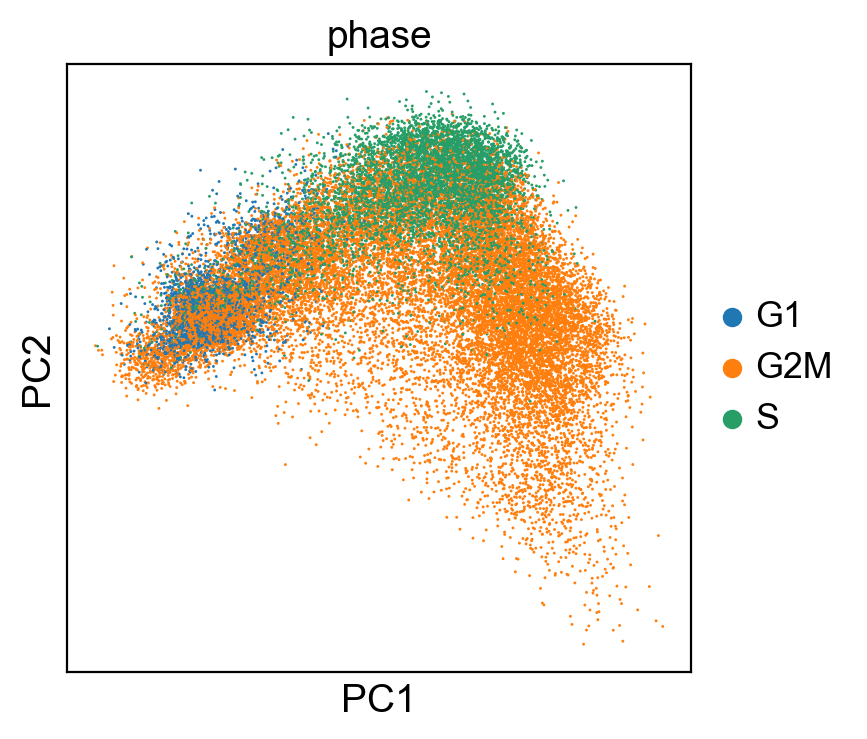

In [41]:
sc.pl.pca_scatter(adata_cc_genes, color='phase')

In [42]:
sc.pp.regress_out(adata, ['G1S_score', 'S_score', 'G2M_score', 'M_score', 'MG1_score'])

d:\Anaconda\envs\scRNA_new\lib\site-packages\scanpy\preprocessing\_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Anaconda\envs\scRNA_new\lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


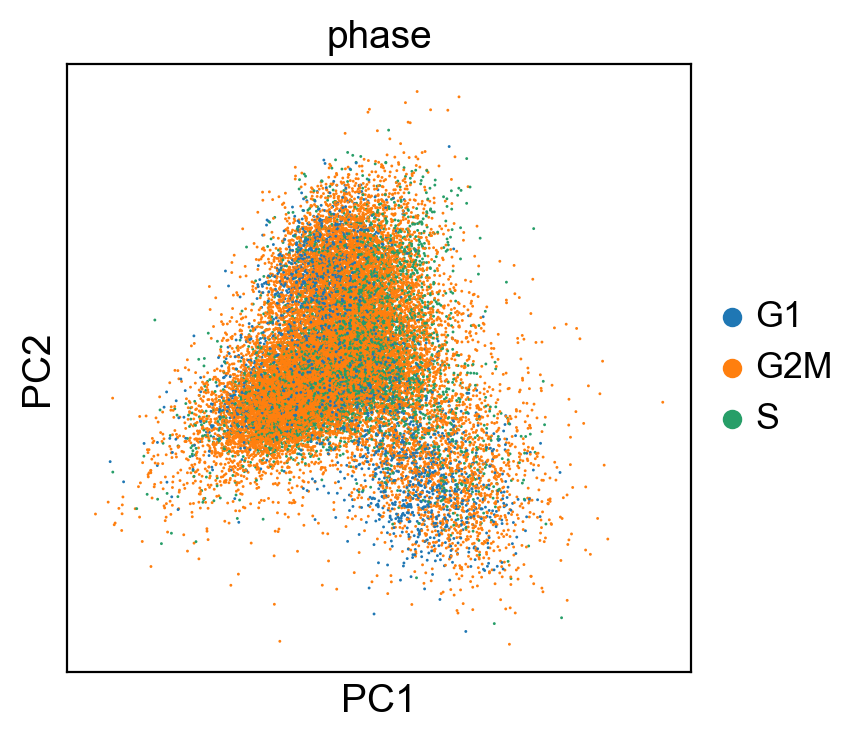

In [43]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.pp.scale(adata_cc_genes, max_value=10) # 也可以把10设定为none
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

In [44]:
# 整体的scale Data
sc.pp.scale(adata, max_value=10)
# pca降维
sc.tl.pca(adata,n_comps=50,use_highly_variable=True)
# 做PCA时直接回归细胞周期效应（无需修改原始表达矩阵）


d:\Anaconda\envs\scRNA_new\lib\site-packages\scanpy\preprocessing\_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


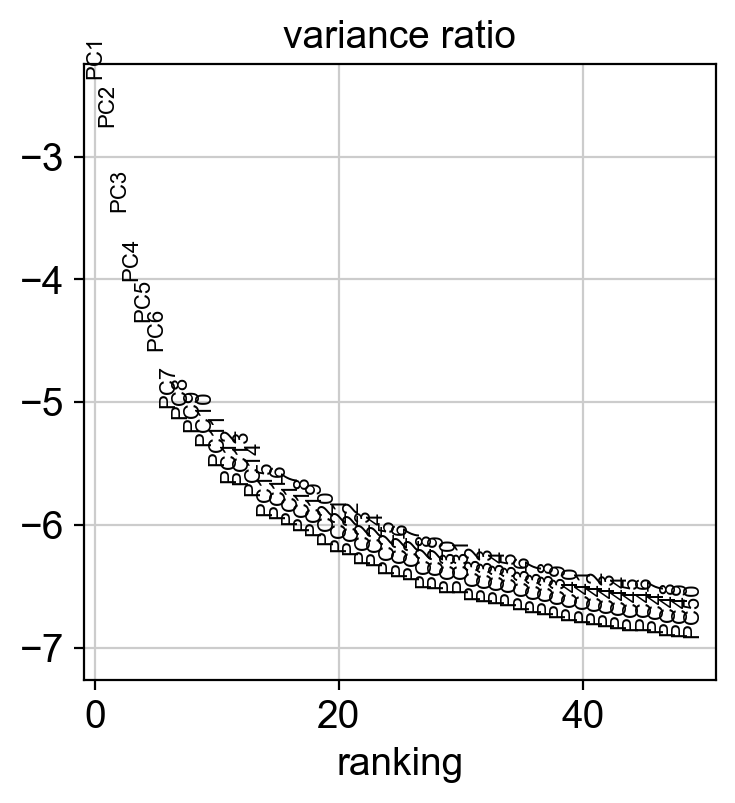

In [45]:
# 这个图就可以选择合适的PCA数值了
sc.pl.pca_variance_ratio(adata,n_pcs=50,log=True)

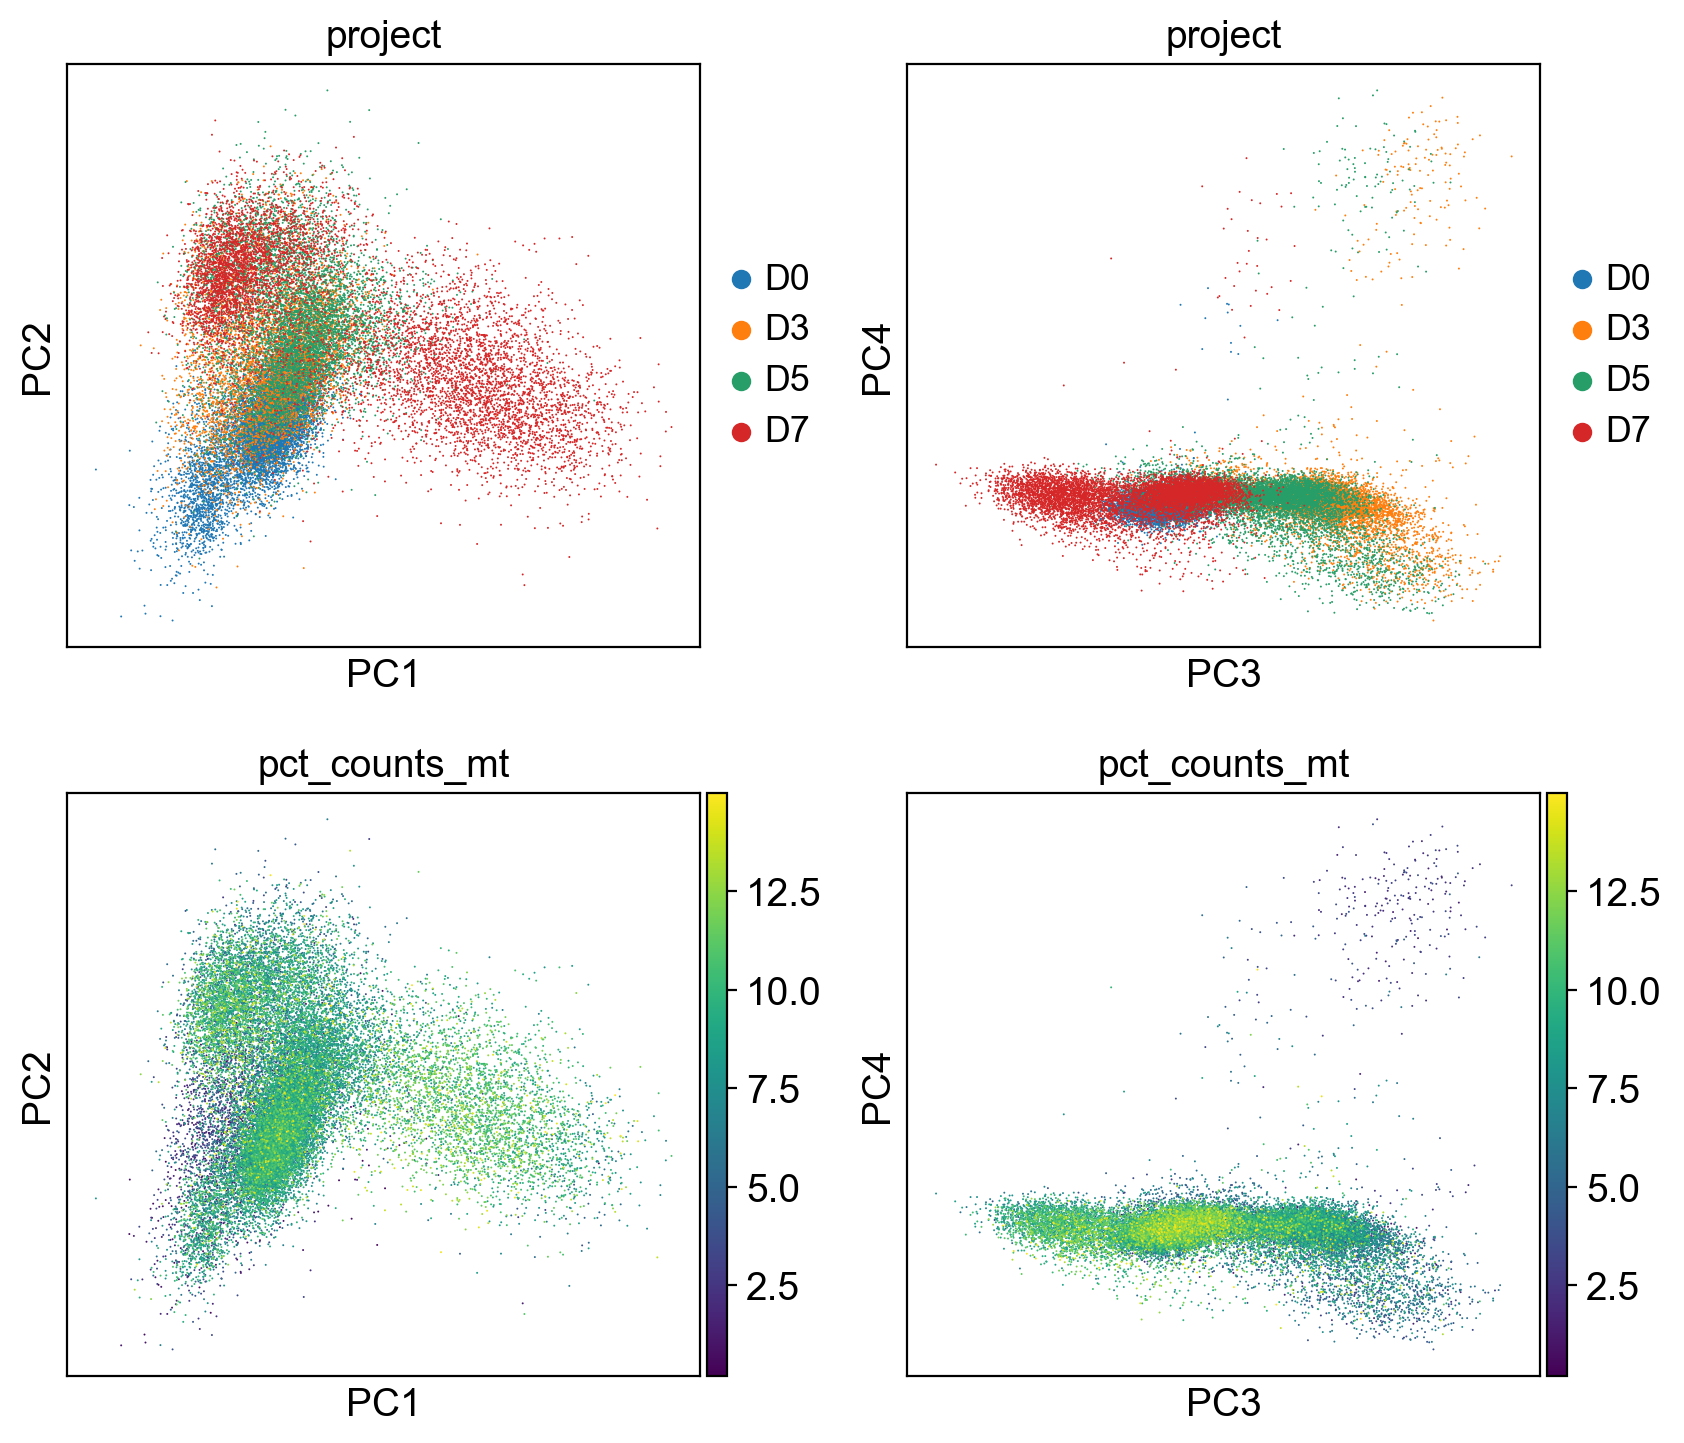

In [46]:

# 按照不同分组检查pca的情况
sc.pl.pca(
    adata,
    color = ["project","project","pct_counts_mt","pct_counts_mt"],# 按照什么参数进行上色
    dimensions=[(0,1),(2,3),(0,1),(2,3)], # 按照不同的pca进行展示
    ncols =2,
    size =2,
    
)

# 2. eliminate batch effect 
#### b. draw the umap/t-sne visualization map before removing batch effects, refer to figure 5A in the original study


d:\Anaconda\envs\scRNA_new\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Anaconda\envs\scRNA_new\lib\site-packages\umap\__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


<Figure size 393.701x393.701 with 0 Axes>

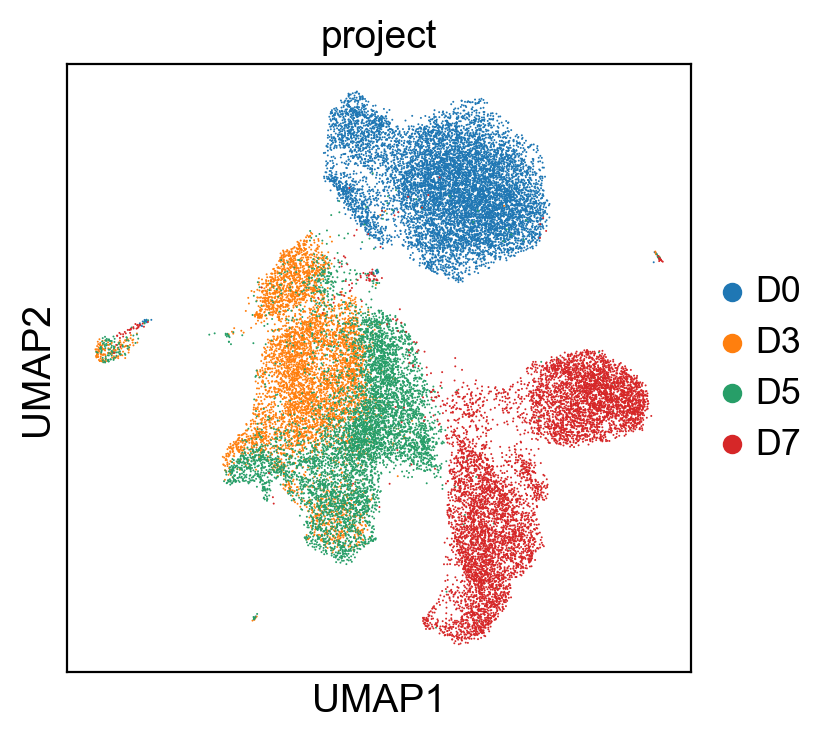

In [47]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)#50参考论文给出的数据
# umap处理
sc.tl.umap(adata)
width_cm = 10
height_cm = 10
plt.figure(figsize=(width_cm / 2.54, height_cm / 2.54))
 
sc.pl.umap(
    adata,
    color="project",
    # Setting a smaller point size to get prevent overlap
    size=2,
    show=False
)
 
plt.savefig("umap_non.pdf",bbox_inches='tight') # 不显示就能保存了。。。。show =False
plt.show()

#### a.The paper uses the mutual nearest neighbor comparison method (haghverdi et al., 2018) to remove batch effects, but this method is based on R language
We used bbknn to eliminate batches
The k-nearest neighbor logic of batch balance: bbknn allows each cell to find neighbors independently in each batch and then merge, avoiding the "over integration" caused by global neighbor finding, and preserving the biological differences of cell types / differentiation stages (adapting to your analysis needs of samples at four differentiation time points); The
Light weight and high efficiency: it does not need to modify the expression matrix, directly optimizes the construction of nearest neighbor graph, has fast calculation and good adaptability to medium-sized datasets (such as thousands of cells per sample); The
Avoid fuzzy grouping: compared with the problem that harmony is easy to "wipe out" cell subpopulations, bbknn can effectively eliminate batch effects, maintain a clear cell cluster structure, and solve the problem of umap sticking together before. 

In [48]:
adata_bb=adata.copy()

In [49]:
import scanpy.external as sce 
# 运行BBKNN（核心参数调整）
sce.pp.bbknn(
    adata_bb,
    batch_key='project',  
    neighbors_within_batch=5,  # 每个批次只找5个邻居（总邻居数=5×4=20，减少跨簇连接）
    n_pcs=50,  # 来自论文建议
    trim=20,  #严格修剪邻居数（只保留最核心的连接）
    approx=True,
    metric='cosine'  # 换成余弦距离（比欧氏更易区分细胞类型）
)

#### b. Draw the visualization map of umap/t-sne after removing batch effects, refer to 5B in the original study.

<Figure size 393.701x393.701 with 0 Axes>

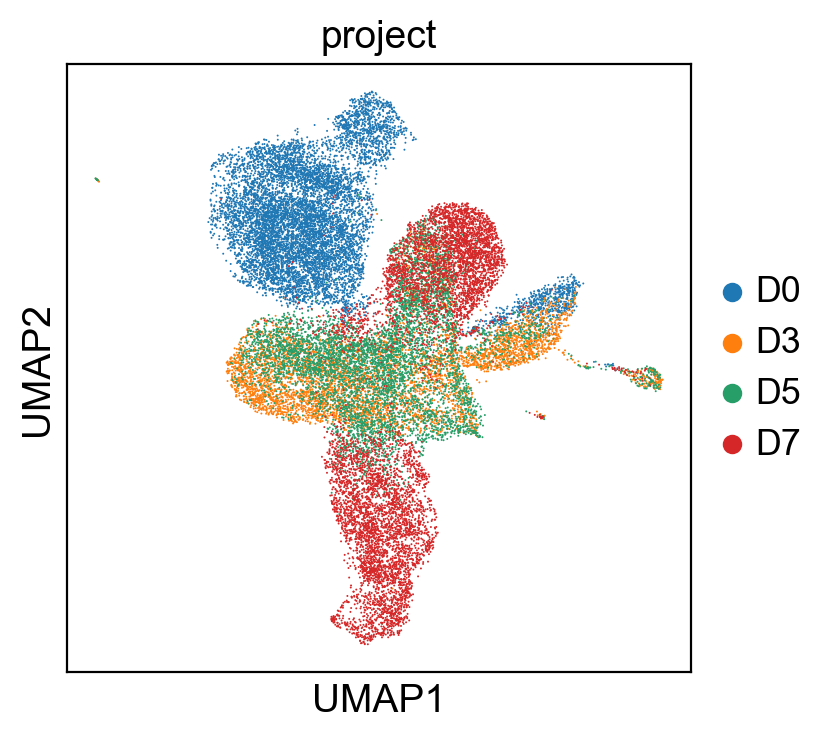

In [50]:
# Then we calculate a new umap and tsne.
#sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, use_rep='X_pca_harmony')
#sc.tl.umap(adata)
sc.tl.umap(
    adata_bb,
    min_dist=0.5,  # 进一步拉大簇间距离
    spread=1.2,    # 让簇更分散
    random_state=42,
)
# sc.tl.tsne(adata, use_rep='X_pca_harmony')
# sc.tl.leiden(adata, resolution=0.5)
width_cm = 10
height_cm = 10
plt.figure(figsize=(width_cm / 2.54, height_cm / 2.54))
 
sc.pl.umap(
    adata_bb,
    color="project",
    # Setting a smaller point size to get prevent overlap
    size=2,
    show=False
)
 
plt.savefig("umap_scanorama.pdf",bbox_inches='tight') 
plt.show()

In [51]:
# 3. 聚类（Leiden算法，调整分辨率）
sc.tl.leiden(
    adata_bb, 
    resolution=0.5,  # 分辨率适中（论文用1.5e-5可能太小，导致簇合并）
    random_state=42
)

C:\Users\李想\AppData\Local\Temp\ipykernel_23460\2147964637.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


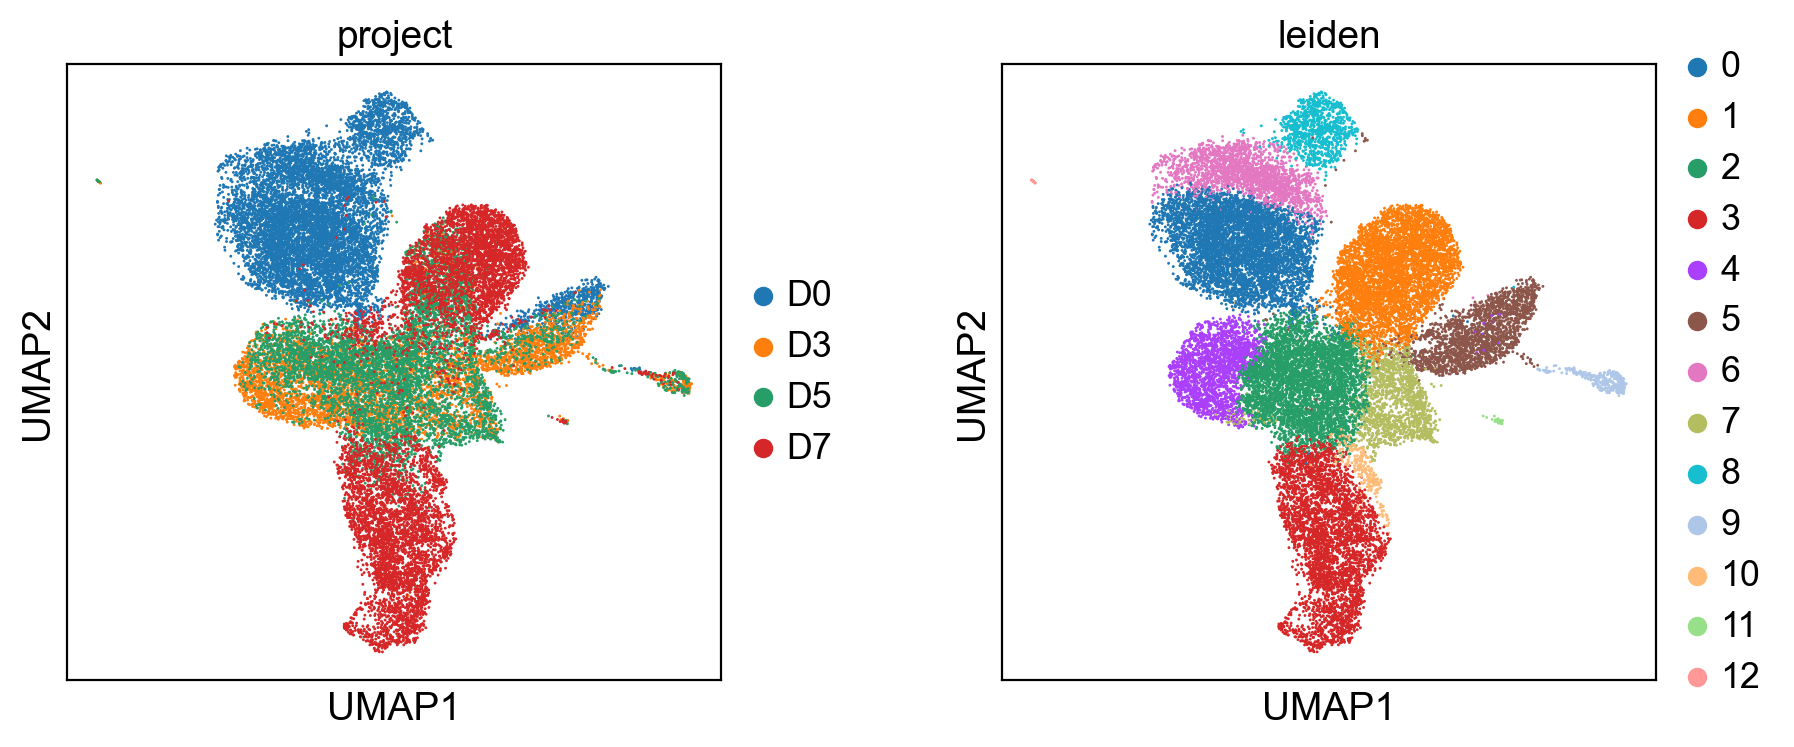

In [52]:
sc.pl.umap(
    adata_bb, 
    color=['project', 'leiden'],  # 批次+聚类簇
    ncols=2,  # 分两列展示
    wspace=0.3,  # 调整间距
)

In [53]:
#del adata  # 删除原有的adata变量
adata=adata_bb


# Cell clustering and annotation 
#### a. perform cell clustering and annotation, refer to figure 5B in the original literature. The marker genes used for annotation are taken from figure 5e-g.

In [54]:
marker_genes = {
    "EB (Erythroblast)": ["GYPA", "KLF1", "EPB42"],  # 对应C1\C2，取自图5E的红细胞相关标记
    "EB_like": ["ITGA2B", "IFI27", "HBD"],  # 对应C2，补充红细胞标记，选自图5D与论文原文
    "iPEM": ["CD44", "LMO4", "ANXA1"],  # 对应C3，取自图5F的标记基因
    "iMK": ['ITGA6','GP1BA','GP9','F2R'], #,'SELP'],  # 对应C4\C5，取自图5G和图5D的巨核细胞标记
    "iMK_2": ['CD53','CD52','KIT']  # 对应C5，补充巨核细胞标记,选自图5I与论文原文
}

In [55]:
# 检查基因是否存在于adata的var_names中
all_genes = adata.var_names.tolist()
marker_genes_check = {
    cell_type: [gene for gene in genes if gene in all_genes] 
    for cell_type, genes in marker_genes.items()
}
# 打印缺失的基因
for cell_type, genes in marker_genes.items():
    missing = [gene for gene in genes if gene not in all_genes]
    if missing:
        print(f"细胞类型 {cell_type} 中缺失的基因：{missing}")

<Figure size 1181.1x393.701 with 0 Axes>

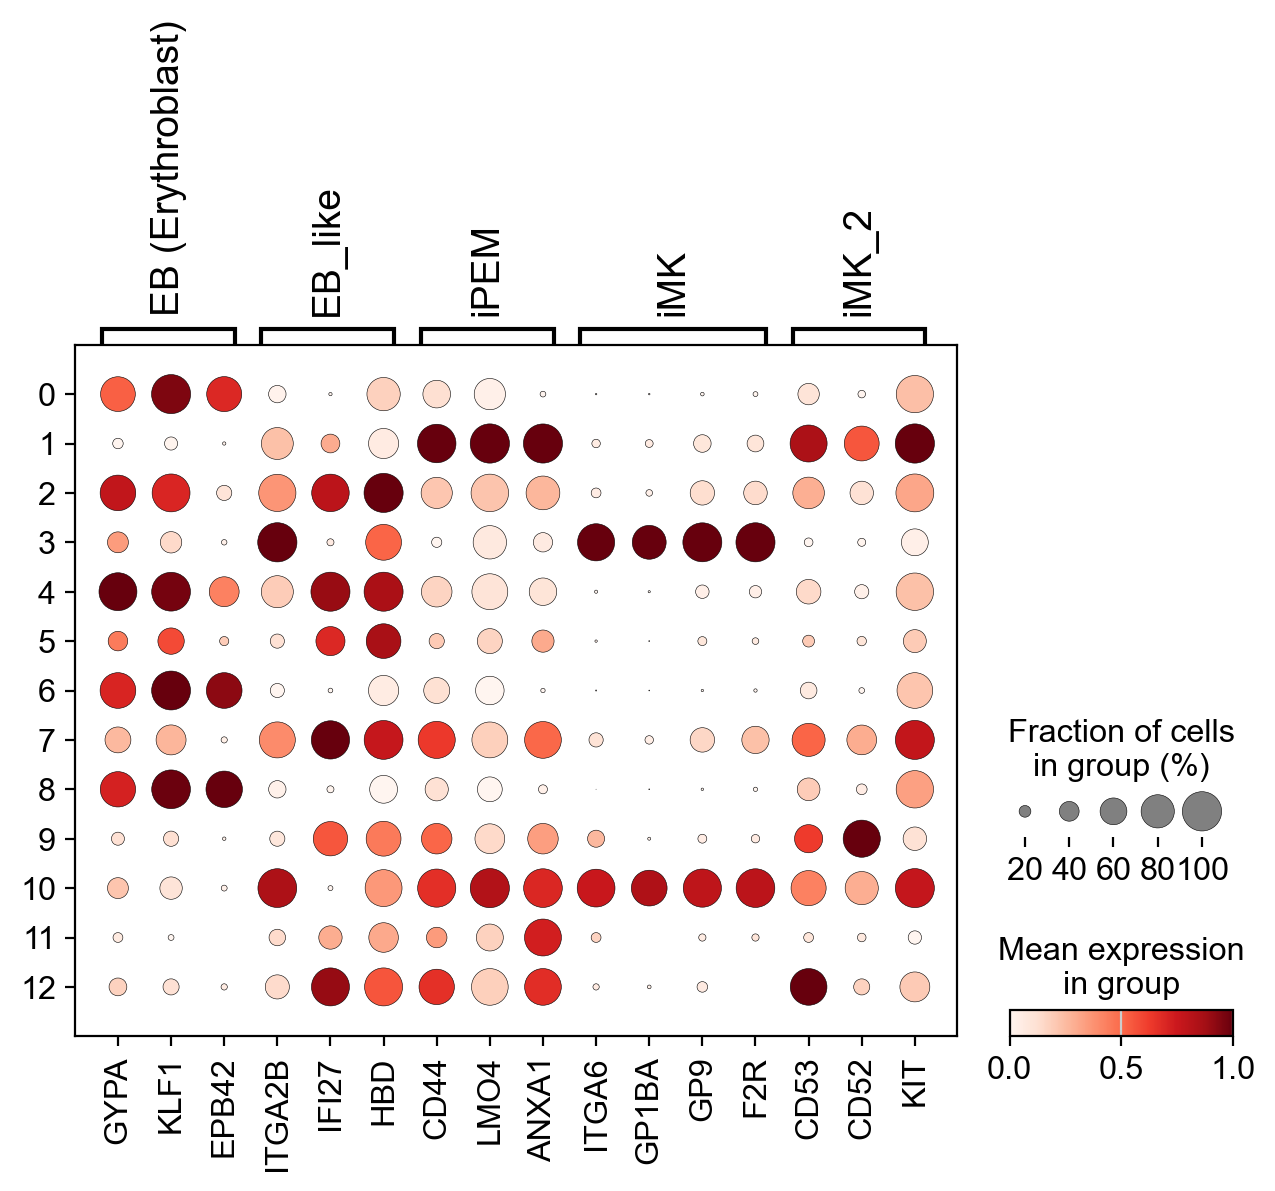

In [56]:
width_cm = 30
height_cm = 10
plt.figure(figsize=(width_cm / 2.54, height_cm / 2.54))
 
sc.pl.dotplot(adata, 
              marker_genes,
              groupby="leiden", 
              standard_scale="var",
             show =False
             )
 
plt.savefig("leiden_marker.pdf",bbox_inches='tight')
plt.show()

In [57]:
# 获取所有cluster ID，排序并转成字符串列表（方便后续匹配）
cluster_ids = sorted(adata.obs['leiden'].unique().tolist())
cluster_ids = [str(c) for c in cluster_ids]  # 转成字符串
 
# 初始化 DataFrame，所有celltype先设为'Unknown'
celltype = pd.DataFrame({
    'ClusterID': cluster_ids,
    'celltype': ['Unknown'] * len(cluster_ids)
})
 
celltype

ClusterID celltype
0          0  Unknown
1          1  Unknown
2         10  Unknown
3         11  Unknown
4         12  Unknown
5          2  Unknown
6          3  Unknown
7          4  Unknown
8          5  Unknown
9          6  Unknown
10         7  Unknown
11         8  Unknown
12         9  Unknown

In [58]:
# 红系前体/红细胞相关
celltype.loc[celltype['ClusterID'].isin(['0', '6', '8','']), 'celltype'] = 'EB (Erythroblast)'
celltype.loc[celltype['ClusterID'].isin(['2', '7','4','5']), 'celltype'] = 'EB-like cells'

# 巨噬前体相关
celltype.loc[celltype['ClusterID'].isin(['1', '', '9','11','12','']), 'celltype'] = 'iPEM cells'

# 巨核细胞系列
celltype.loc[celltype['ClusterID'].isin(['3', ' ']), 'celltype'] = 'iMK_1 cells'
celltype.loc[celltype['ClusterID'].isin(['10']), 'celltype'] = 'iMK_2 cells'



In [59]:
# 接下来，将celltype信息映射回adata.obs
# 先确保adata.obs里的cluster列也是字符串形式
adata.obs['leiden_str'] = adata.obs['leiden'].astype(str)
 
# 建立映射字典：cluster_id -> celltype
mapping = dict(zip(celltype['ClusterID'], celltype['celltype']))
 
# 用映射字典给每个cell添加celltype信息 增加了celltype这一列
adata.obs['celltype'] = adata.obs['leiden_str'].map(mapping)
 
# 查看一下分布
print(adata.obs['celltype'].value_counts())

EB-like cells        10340
EB (Erythroblast)     8365
iPEM cells            5376
iMK_1 cells           3764
iMK_2 cells            237
Name: celltype, dtype: int64


#### b. Create t-sne/umap maps with cell type annotations, as shown in Figure 5B.

<Figure size 393.701x393.701 with 0 Axes>

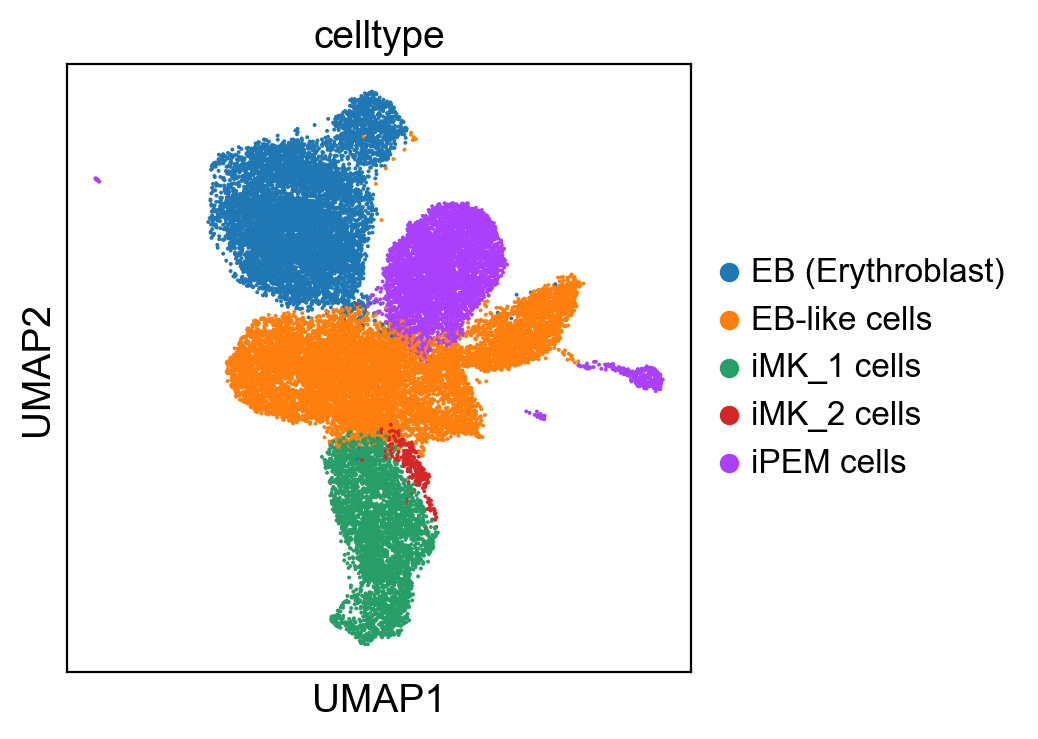

In [60]:
width_cm = 10
height_cm = 10
plt.figure(figsize=(width_cm / 2.54, height_cm / 2.54))
fig = sc.pl.umap(
    adata,
    color=["celltype"],
    #legend_loc="on data",
    frameon=True,
    size=8,            # 调整点大小，可根据需要改
    legend_fontsize=12, # 调整图例字体大小
    show=False)
 
# 遍历所有文本对象，调节字体大小
for txt in fig.axes.texts:
    txt.set_fontsize(7)  # 你想要的字体大小
 
 
plt.savefig("celltype.pdf",bbox_inches='tight') 
plt.show()

#### c. Referring to Figures 5d and 5h, draw a heatmap and violin plots of the within-cluster marker-gene expression.

<Figure size 1181.1x393.701 with 0 Axes>

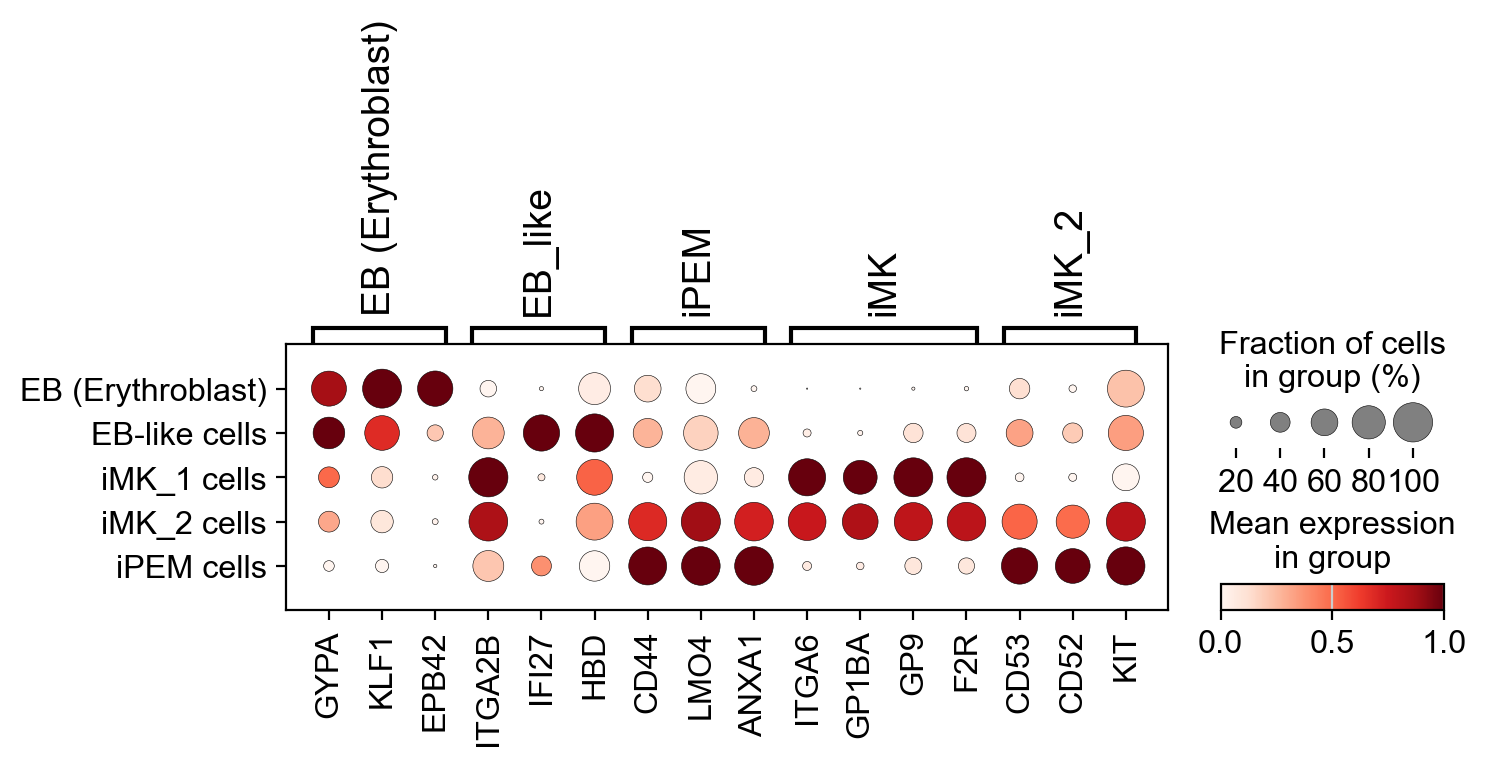

In [61]:
width_cm = 30
height_cm = 10
plt.figure(figsize=(width_cm / 2.54, height_cm / 2.54))
 
sc.pl.dotplot(adata, 
              marker_genes,
              groupby="celltype", 
              standard_scale="var",
             show =False
             )
 
plt.savefig("celltype_marker.pdf",bbox_inches='tight')
plt.show()

<Figure size 1181.1x393.701 with 0 Axes>

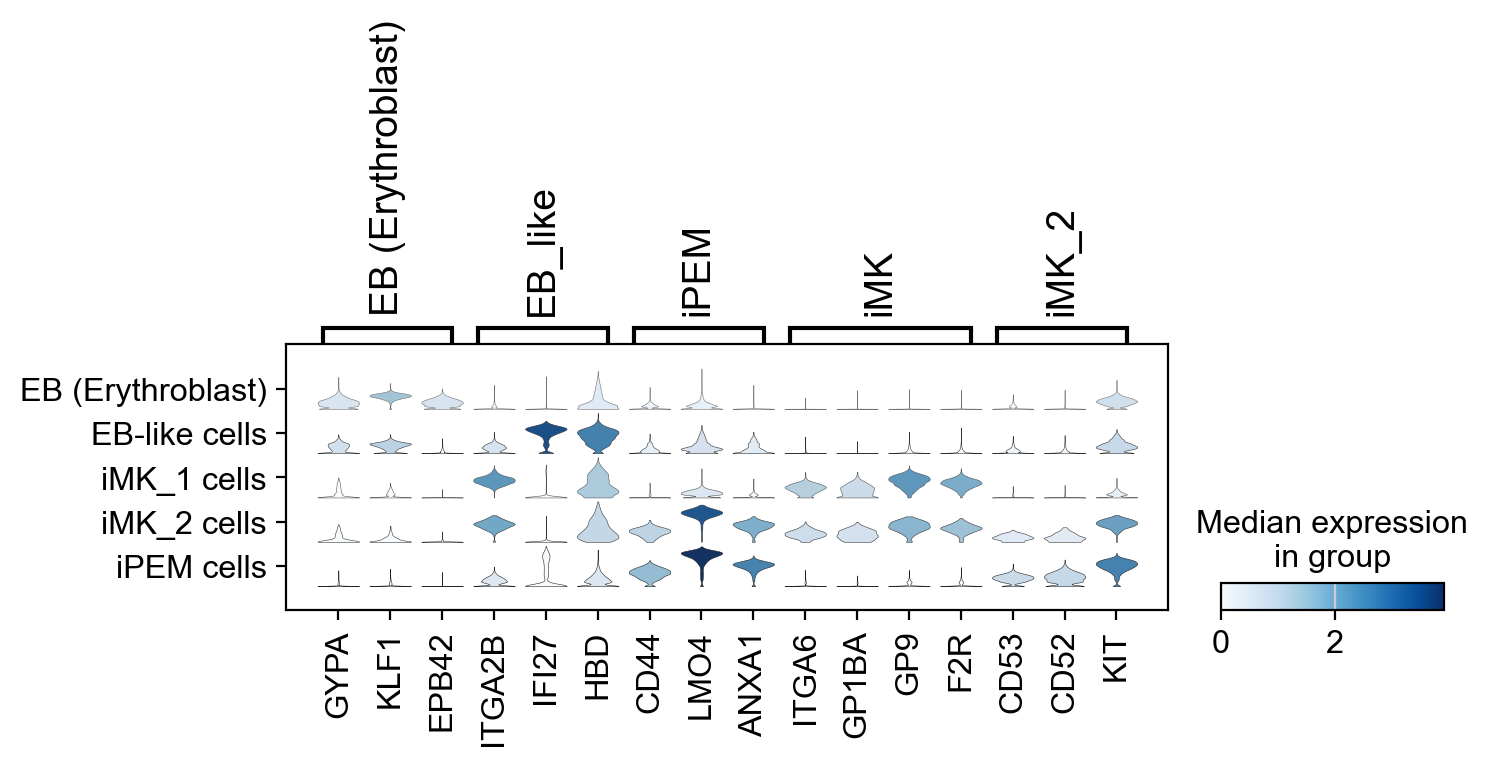

<Figure size 400x400 with 0 Axes>

In [62]:
width_cm = 30
height_cm = 10
plt.figure(figsize=(width_cm / 2.54, height_cm / 2.54))
 
sc.pl.stacked_violin(adata, 
                     marker_genes,
                     groupby="celltype")
 
plt.savefig("celltype_marker2.pdf",bbox_inches='tight',dpi=300)
plt.show()

#### d. As shown in Figure 5c, visualize the sample proportions for each cell-type cluster.

In [63]:
import seaborn as sns

In [64]:
# 1. 统计每个细胞类型-样本的细胞数量
counts = adata.obs.groupby(['celltype', 'project']).size().reset_index(name='count')

# 2. 计算每个细胞类型在各样本中的比例
celltype_totals = counts.groupby('celltype')['count'].sum()  # 每个细胞类型的总细胞数
counts['proportion'] = counts.apply(lambda x: x['count'] / celltype_totals[x['celltype']], axis=1)

# 3. 转换为透视表（方便绘图）
proportion_pivot = counts.pivot(index='celltype', columns='project', values='proportion').fillna(0)

In [65]:
cell_order = ["EB (Erythroblast)", "EB-like cells", "iPEM cells", "iMK_1 cells", "iMK_2 cells"]
proportion_pivot = proportion_pivot.reindex(cell_order)  # 按指定顺序重新排序行

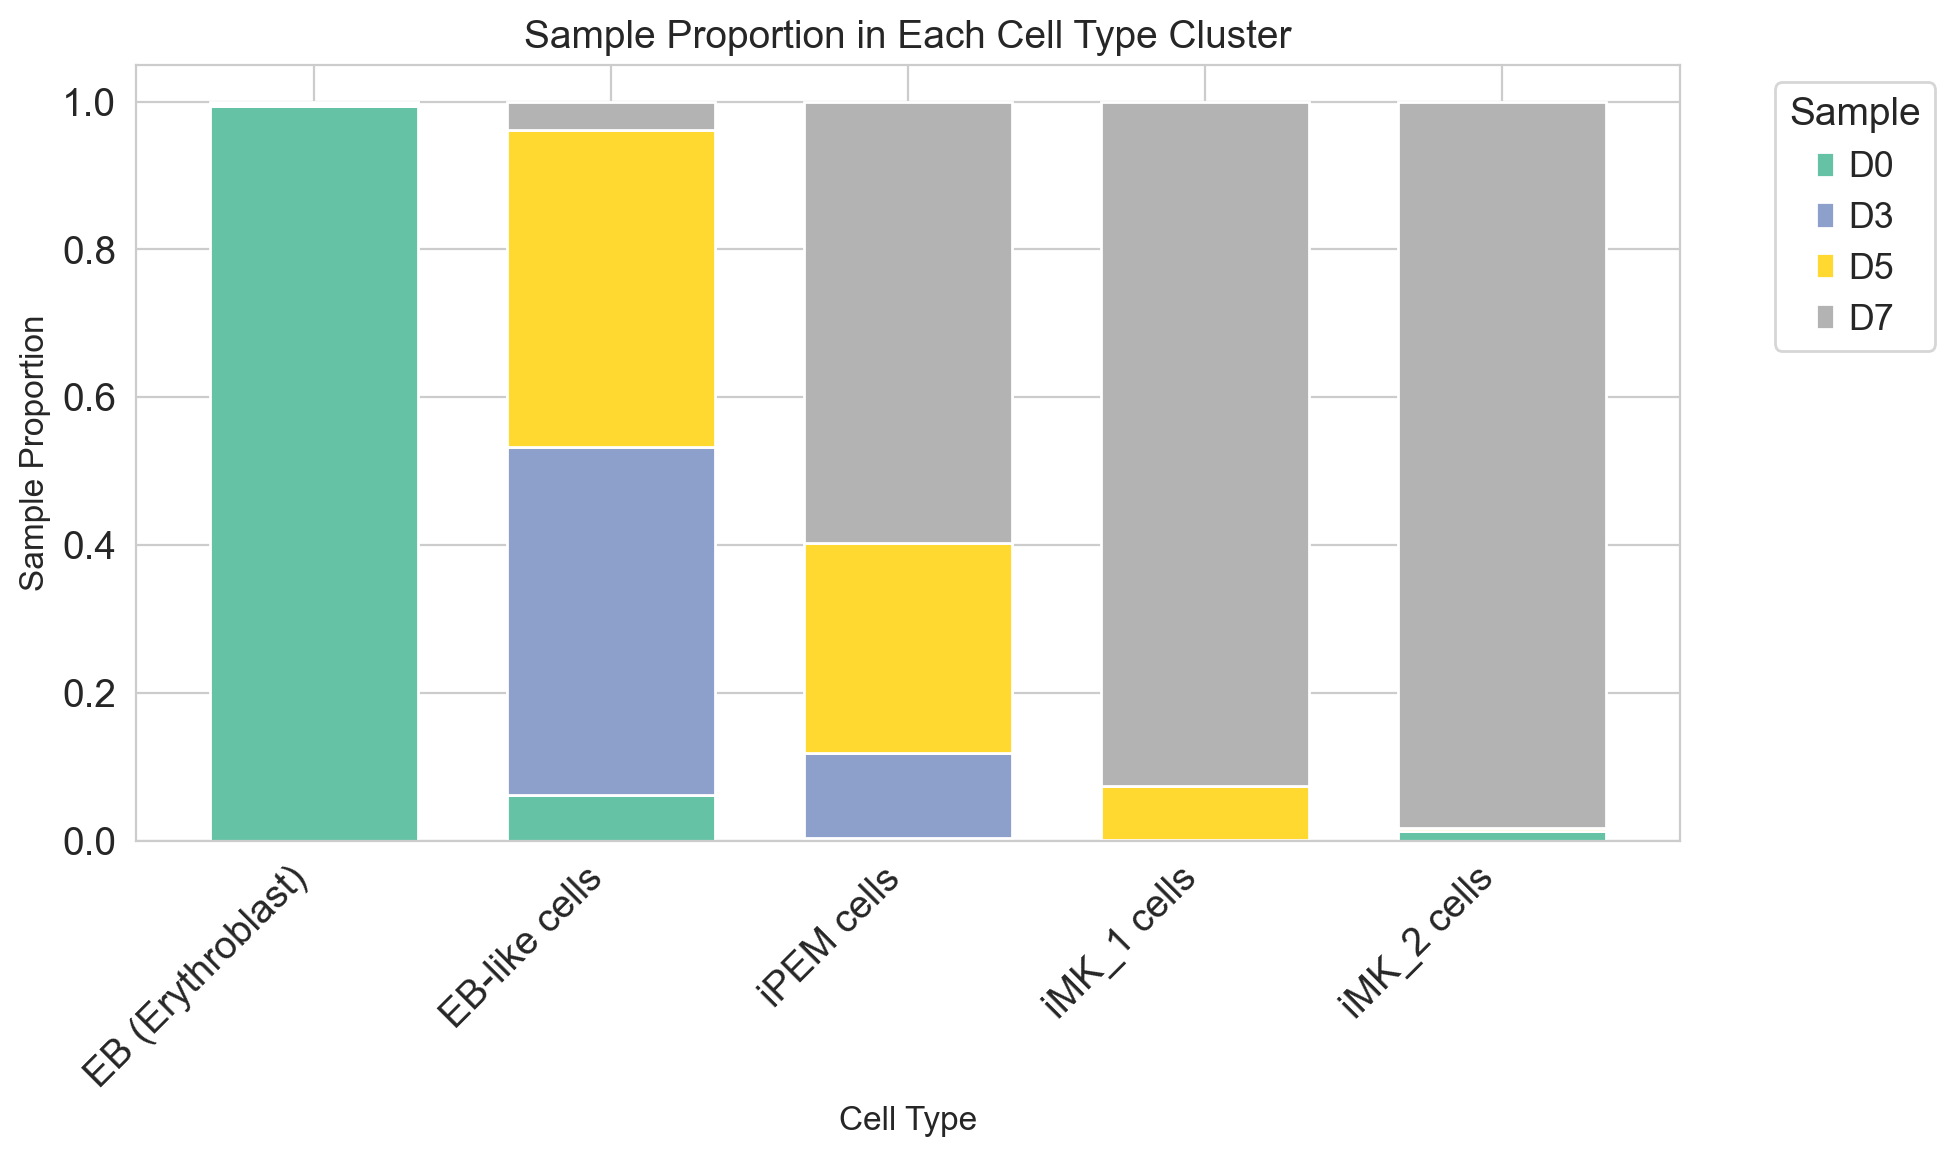

In [66]:
# 设置绘图样式
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')

# 绘制堆叠柱状图
proportion_pivot.plot(
    kind='bar', 
    stacked=True, 
    ax=plt.gca(),
    colormap='Set2',  # 配色方案，可替换为'viridis'/'tab10'等
    width=0.7  # 柱子宽度
)

# 添加标签和标题
plt.xlabel('Cell Type', fontsize=12)
plt.ylabel('Sample Proportion', fontsize=12)
plt.title('Sample Proportion in Each Cell Type Cluster', fontsize=14)
plt.xticks(rotation=45, ha='right')  # 旋转x轴标签，避免重叠
plt.legend(title='Sample', bbox_to_anchor=(1.05, 1), loc='upper left')  # 图例放右侧

# 调整布局并保存
plt.tight_layout()
plt.savefig('celltype_sample_proportion.pdf', dpi=300)
plt.show()

# GO Enrichment Analysis of Cell-Cluster Marker Genes

#### a. Select two cell clusters and perform GO enrichment analysis, referring to Figure 5j.

#### b. Present and interpret the GO enrichment results.

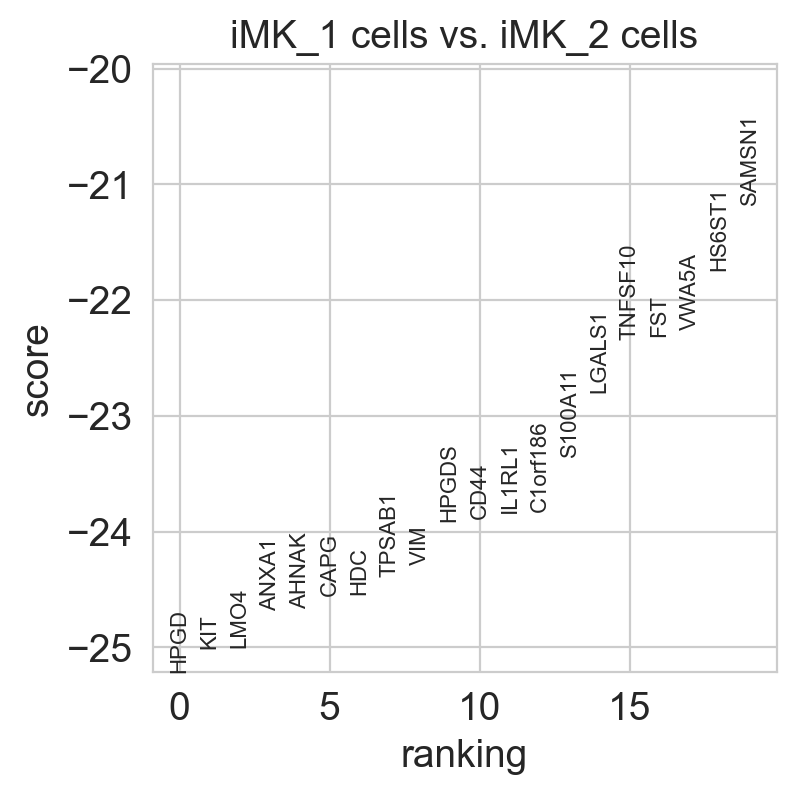

In [67]:
sc.tl.rank_genes_groups(
    adata, 
    groupby="celltype",       # 仍按细胞类型分组
    groups=["iMK_1 cells"],         # 要测试的簇（iMK-1）
    reference="iMK_2 cells",        # 对照组（iMK-2）
    method="wilcoxon",        # 单细胞差异分析常用方法（也可用t-test、logreg等）
    rankby_abs=True           # 按差异显著性的绝对值排序（可选）
)

# 查看差异结果（iMK-1相对于iMK-2高表达的基因）
sc.pl.rank_genes_groups(adata, groups=["iMK_1 cells"], n_genes=20, sharey=False)

# 提取差异基因（iMK-1高表达）
imk1_markers = sc.get.rank_genes_groups_df(adata, group="iMK_1 cells", log2fc_min=0.5, pval_cutoff=0.05)

In [68]:
# 使用gseapy进行GO/KEGG富集分析
import  gseapy  as  gp

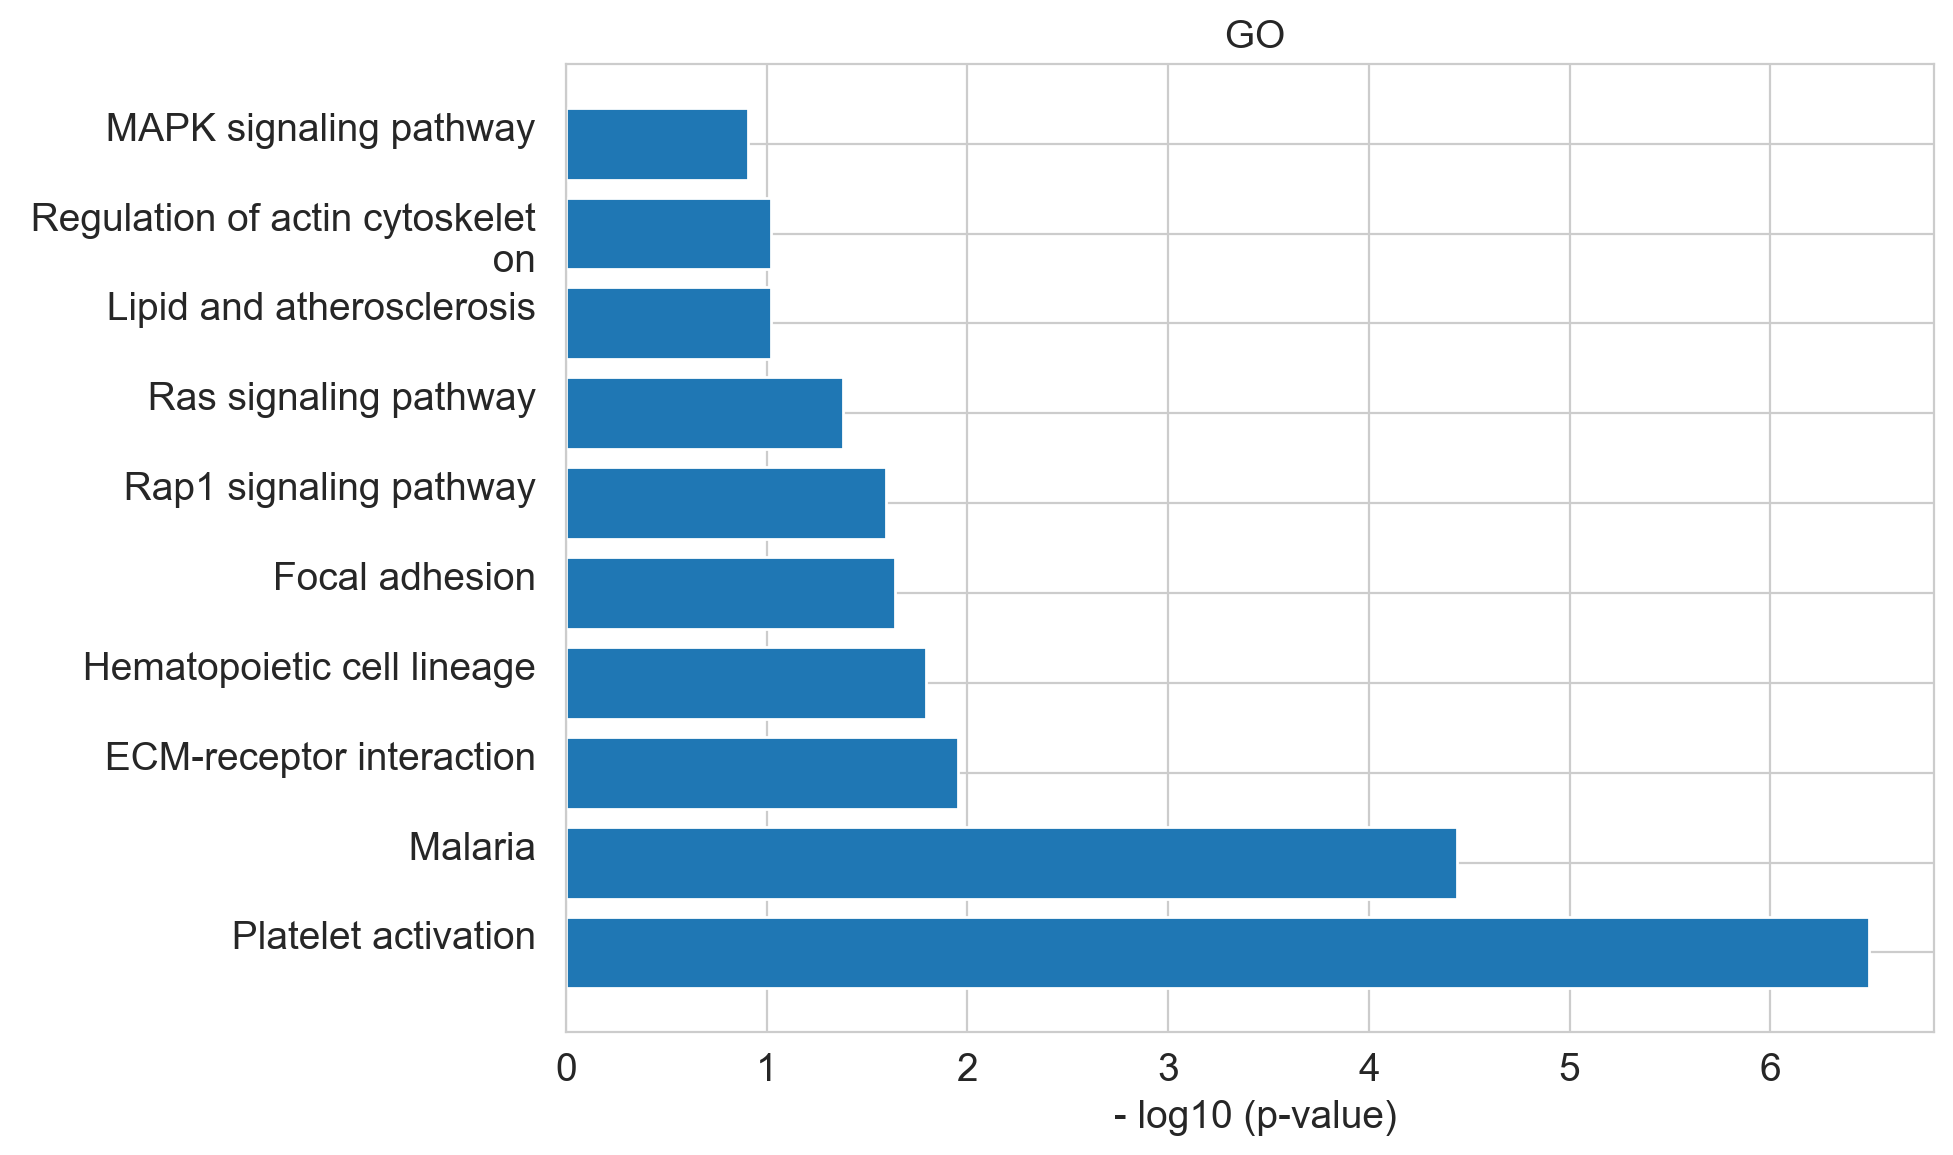

In [74]:
enrichment_results  =  gp.enrichr ( gene_list = 
    imk1_markers['names'] , gene_sets = [ 'GO_Biological_Process_2021' , 'KEGG_2021_Human' ], organism = 'human' , outdir = None , cutoff = 0.05 )
plt.figure(figsize=(10, 6))

#GO生物过程
go_bp  =  enrichment_results.results [ enrichment_results.results [ 'Gene_set'] == 'GO_Biological_Process_2021' ] . head ( 10 ) 
plt.barh ( range ( len ( go_bp ) ) , -np.log10 ( go_bp [ 'Adjusted P-value' ])) 
plt.yticks ( range ( len ( go_bp )), [ term [ : 30 ] for term in go_bp [ 'Term' ] ]) 
plt.xlabel ( ' - log10 (p-value)' ) 
plt.title ( ' GO' ) 
plt. yticks ( range ( len ( go_bp )), [ " {} \n {} " . format ( term [: 30 ], term [ 30 : 60 ]) for term in go_bp [ 'Term' ]]) 
plt.tight_layout ()
      

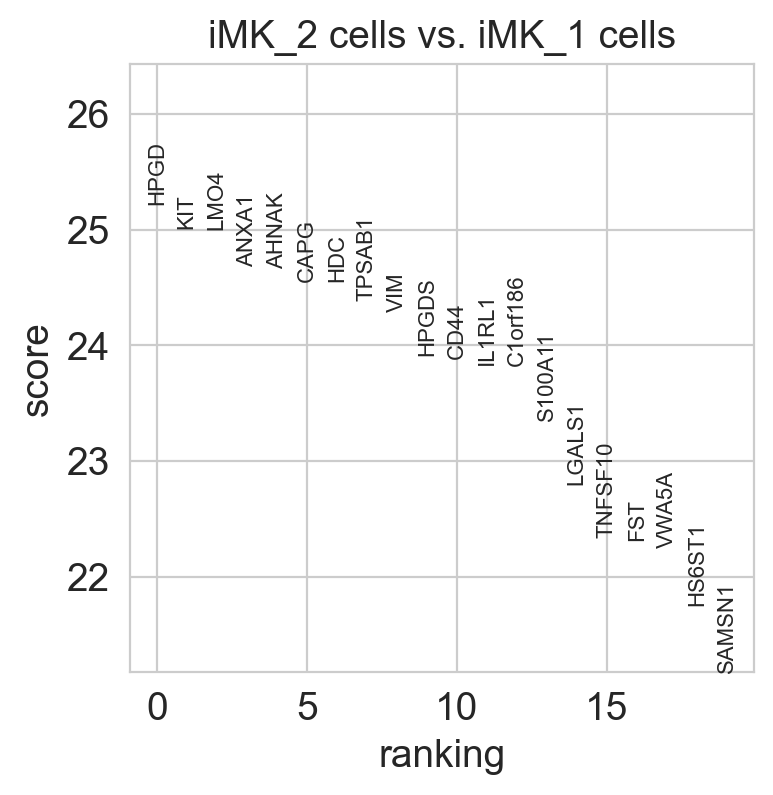

In [75]:
sc.tl.rank_genes_groups(
    adata, 
    groupby="celltype",       # 仍按细胞类型分组
    groups=["iMK_2 cells"],         # 要测试的簇（iMK-1）
    reference="iMK_1 cells",        # 对照组（iMK-2）
    method="wilcoxon",        # 单细胞差异分析常用方法（也可用t-test、logreg等）
    rankby_abs=True           # 按差异显著性的绝对值排序（可选）
)

# 查看差异结果（iMK-1相对于iMK-2高表达的基因）
sc.pl.rank_genes_groups(adata, groups=["iMK_2 cells"], n_genes=20, sharey=False)

# 提取差异基因（iMK-1高表达）
imk2_markers = sc.get.rank_genes_groups_df(adata, group="iMK_2 cells", log2fc_min=0.5, pval_cutoff=0.05)

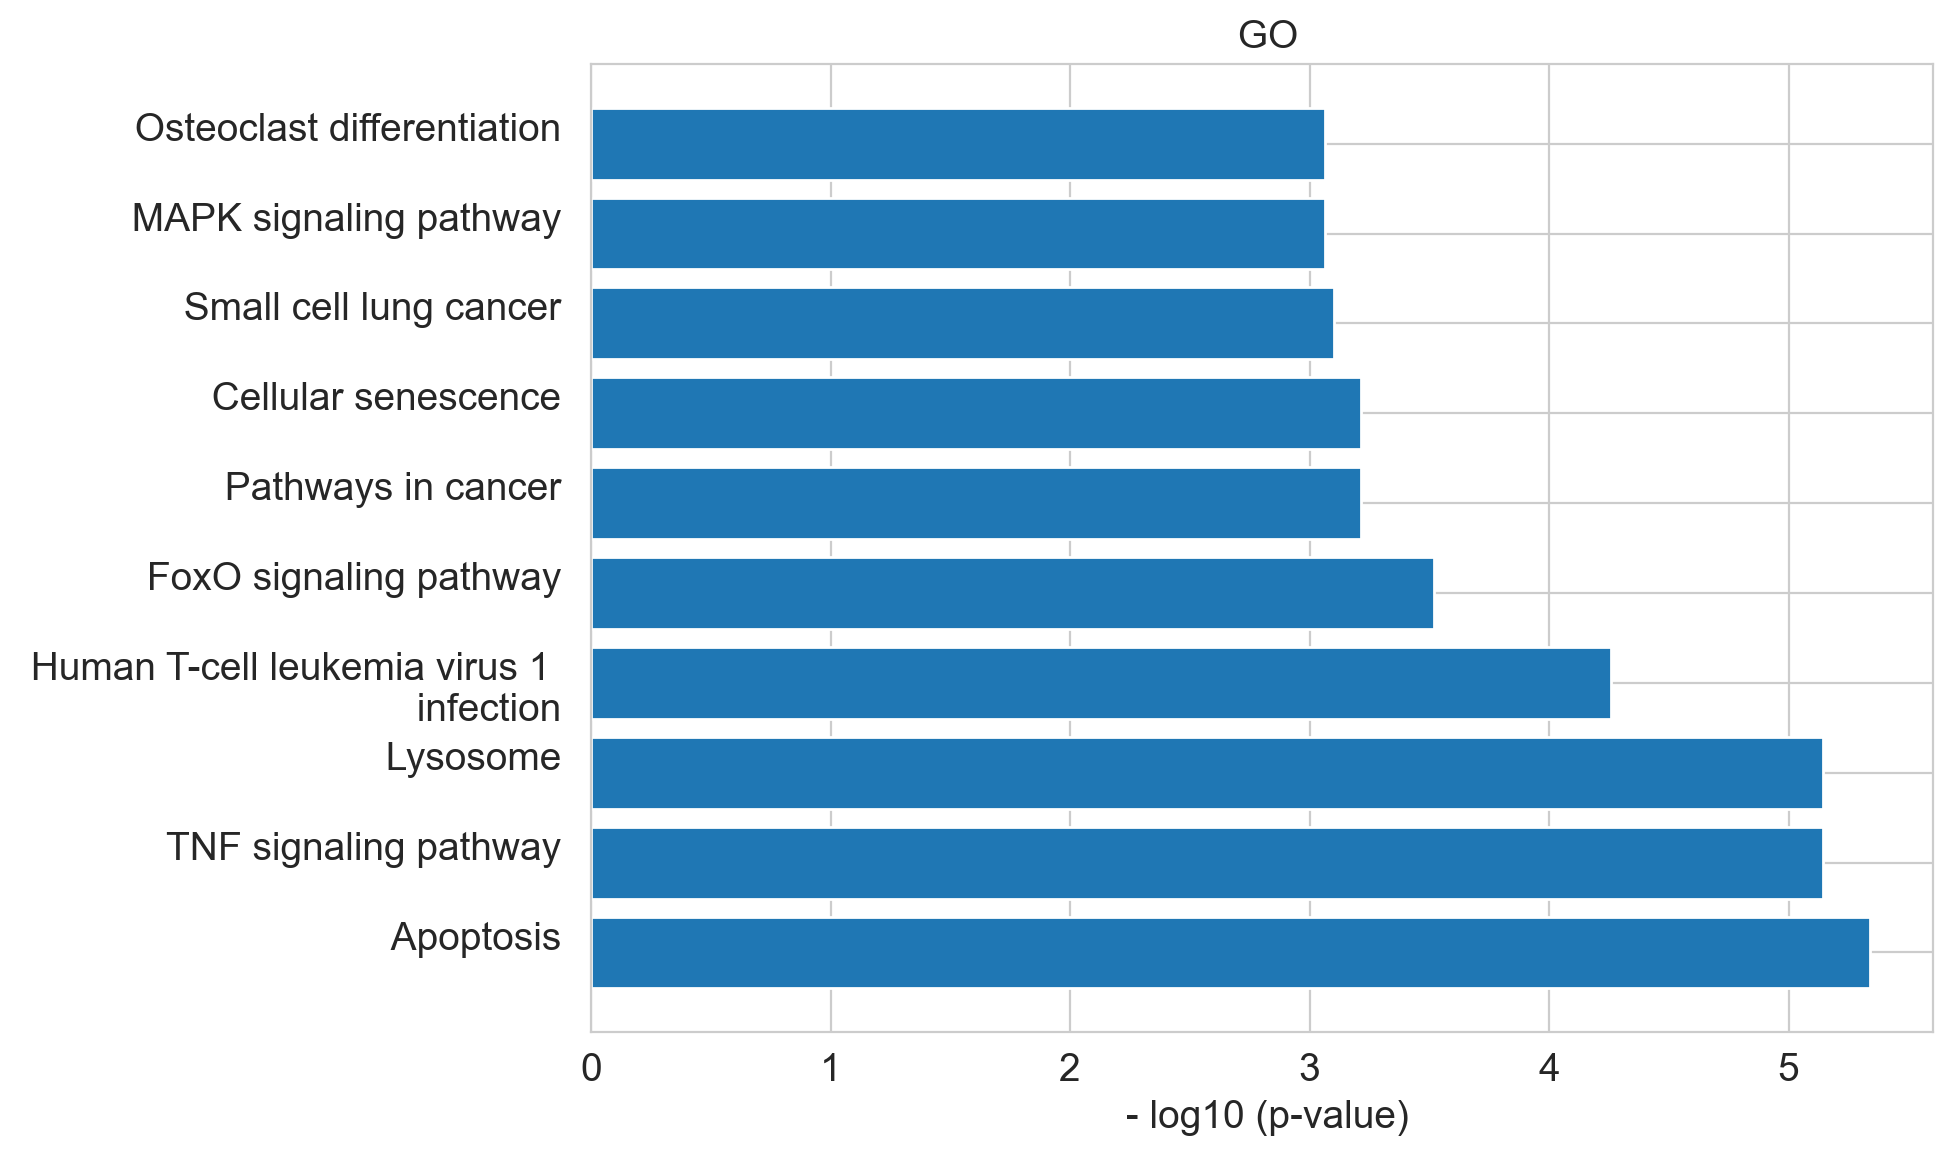

In [76]:
enrichment_results  =  gp.enrichr ( gene_list = 
    imk2_markers['names'] , gene_sets = [ 'GO_Biological_Process_2021' , 'KEGG_2021_Human' ], organism = 'human' , outdir = None , cutoff = 0.05 )
plt.figure(figsize=(10, 6))

#GO生物过程
go_bp  =  enrichment_results.results [ enrichment_results.results [ 'Gene_set'] == 'GO_Biological_Process_2021' ] . head ( 10 ) 
plt.barh ( range ( len ( go_bp ) ) , -np.log10 ( go_bp [ 'Adjusted P-value' ])) 
plt.yticks ( range ( len ( go_bp )), [ term [ : 30 ] for term in go_bp [ 'Term' ] ]) 
plt.xlabel ( ' - log10 (p-value)' ) 
plt.title ( ' GO' ) 
plt. yticks ( range ( len ( go_bp )), [ " {} \n {} " . format ( term [: 30 ], term [ 30 : 60 ]) for term in go_bp [ 'Term' ]]) 
plt.tight_layout ()

In [ ]:
#计算全样本平均doublet_score
global_mean_doublet = adata.obs['doublet_score'].mean()
print(f"全样本平均doublet_score: {global_mean_doublet:.4f}")

#计算iMK_2簇的平均doublet_score
imk2_mean_doublet = adata.obs[adata.obs['celltype'] == 'iMK_2 cells']['doublet_score'].mean()
print(f"iMK_2簇平均doublet_score: {imk2_mean_doublet:.4f}")

全样本平均doublet_score: 0.0646
iMK_2簇平均doublet_score: 0.3239
